In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the original data
X = pd.read_csv('X_data.csv').values
y = pd.read_csv('Y_data.csv').values.ravel()  # Assuming Y is already log-transformed

print(f"Original X shape: {X.shape}")
print(f"Original y shape: {y.shape}")

# Preprocess features with StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define cross-validation strategy
k_folds = 5
cv = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Function to evaluate model using cross-validation
def evaluate_model_cv(model, X, y, model_name, cv=cv):
    # Perform cross-validation
    print(f"\nPerforming {k_folds}-fold cross-validation for {model_name}...")
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
    
    # Get cross-validated predictions
    y_pred_cv = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
    
    # Calculate metrics on log scale
    r2 = r2_score(y, y_pred_cv)
    mse = mean_squared_error(y, y_pred_cv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred_cv)
    
    # Calculate metrics on original scale
    y_orig = np.expm1(y)
    y_pred_orig = np.expm1(y_pred_cv)
    y_pred_orig = np.maximum(y_pred_orig, 0)  # No negative predictions
    
    r2_orig = r2_score(y_orig, y_pred_orig)
    mse_orig = mean_squared_error(y_orig, y_pred_orig)
    rmse_orig = np.sqrt(mse_orig)
    mae_orig = mean_absolute_error(y_orig, y_pred_orig)
    
    # Print cross-validation results
    print(f"Cross-validation R² scores: {cv_scores}")
    print(f"Mean CV R² score: {cv_scores.mean():.4f}")
    print(f"Standard deviation: {cv_scores.std():.4f}")
    
    # Print overall metrics
    print(f"\n{model_name} Performance (using cross-validated predictions):")
    print(f"R² Score (log scale): {r2:.4f}")
    print(f"RMSE (log scale): {rmse:.4f}")
    print(f"MAE (log scale): {mae:.4f}")
    
    print(f"\nOriginal Scale Performance:")
    print(f"R² Score: {r2_orig:.4f}")
    print(f"RMSE: {rmse_orig:.2f}")
    print(f"MAE: {mae_orig:.2f}")
    
    # Create visualization plots
    plt.figure(figsize=(20, 10))
    
    # Actual vs Predicted (log scale)
    plt.subplot(2, 3, 1)
    plt.scatter(y, y_pred_cv, alpha=0.5)
    
    # Add perfect prediction line
    max_val = max(max(y), max(y_pred_cv))
    min_val = min(min(y), min(y_pred_cv))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.title(f'{model_name}: Actual vs Predicted (Log Scale)')
    plt.xlabel('Actual log(DON+1)')
    plt.ylabel('Predicted log(DON+1)')
    
    # Add metrics to plot
    plt.text(0.05, 0.95, f'R²: {r2:.4f}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}',
             transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # Actual vs Predicted (original scale)
    plt.subplot(2, 3, 2)
    plt.scatter(y_orig, y_pred_orig, alpha=0.5)
    
    max_val = max(max(y_orig), max(y_pred_orig))
    min_val = min(min(y_orig), min(y_pred_orig))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.title(f'{model_name}: Actual vs Predicted (Original Scale)')
    plt.xlabel('Actual DON (ppb)')
    plt.ylabel('Predicted DON (ppb)')
    
    plt.text(0.05, 0.95, f'R²: {r2_orig:.4f}\nRMSE: {rmse_orig:.2f}\nMAE: {mae_orig:.2f}',
             transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # Residuals
    plt.subplot(2, 3, 3)
    residuals = y_pred_cv - y
    plt.scatter(y_pred_cv, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot (Log Scale)')
    plt.xlabel('Predicted log(DON+1)')
    plt.ylabel('Residuals')
    
    # Histogram of residuals
    plt.subplot(2, 3, 4)
    plt.hist(residuals, bins=30, alpha=0.7)
    plt.title('Residual Distribution')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    
    # Distribution comparison
    plt.subplot(2, 3, 5)
    plt.hist(y, bins=20, alpha=0.5, label='Actual')
    plt.hist(y_pred_cv, bins=20, alpha=0.5, label='Predicted')
    plt.title('Distribution Comparison (Log Scale)')
    plt.xlabel('log(DON+1)')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Original scale distribution comparison
    plt.subplot(2, 3, 6)
    plt.hist(y_orig, bins=20, alpha=0.5, label='Actual')
    plt.hist(y_pred_orig, bins=20, alpha=0.5, label='Predicted')
    plt.title('Distribution Comparison (Original Scale)')
    plt.xlabel('DON (ppb)')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Fit model on full dataset for feature importance plotting
    model.fit(X, y)
    
    return {
        'model_name': model_name,
        'cv_scores': cv_scores,
        'mean_cv_r2': cv_scores.mean(),
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'r2_orig': r2_orig,
        'rmse_orig': rmse_orig,
        'mae_orig': mae_orig,
        'model': model
    }

Original X shape: (500, 447)
Original y shape: (500,)



Random Forest Regressor

Performing 5-fold cross-validation for Random Forest...
Cross-validation R² scores: [0.16765061 0.21509704 0.23681388 0.06628249 0.17812866]
Mean CV R² score: 0.1728
Standard deviation: 0.0588

Random Forest Performance (using cross-validated predictions):
R² Score (log scale): 0.1769
RMSE (log scale): 2.6783
MAE (log scale): 2.0690

Original Scale Performance:
R² Score: 0.0659
RMSE: 12644.47
MAE: 3122.67


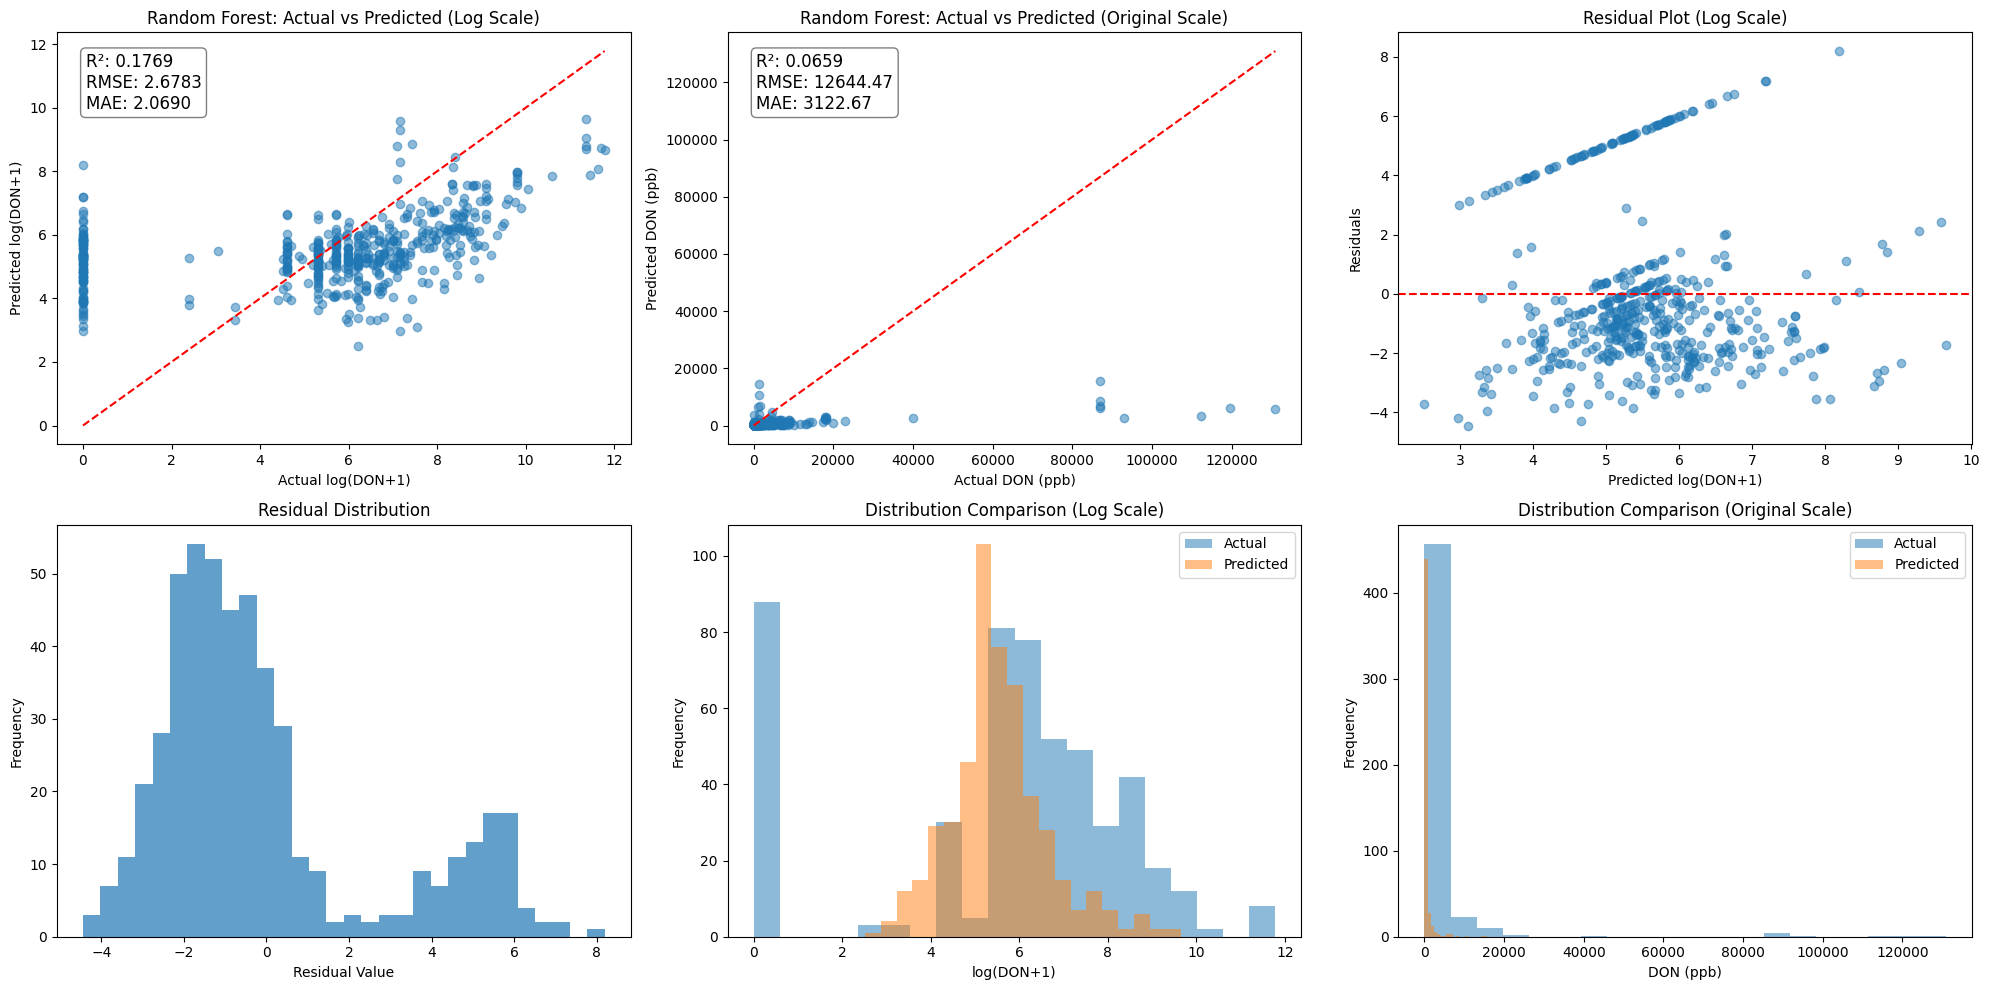

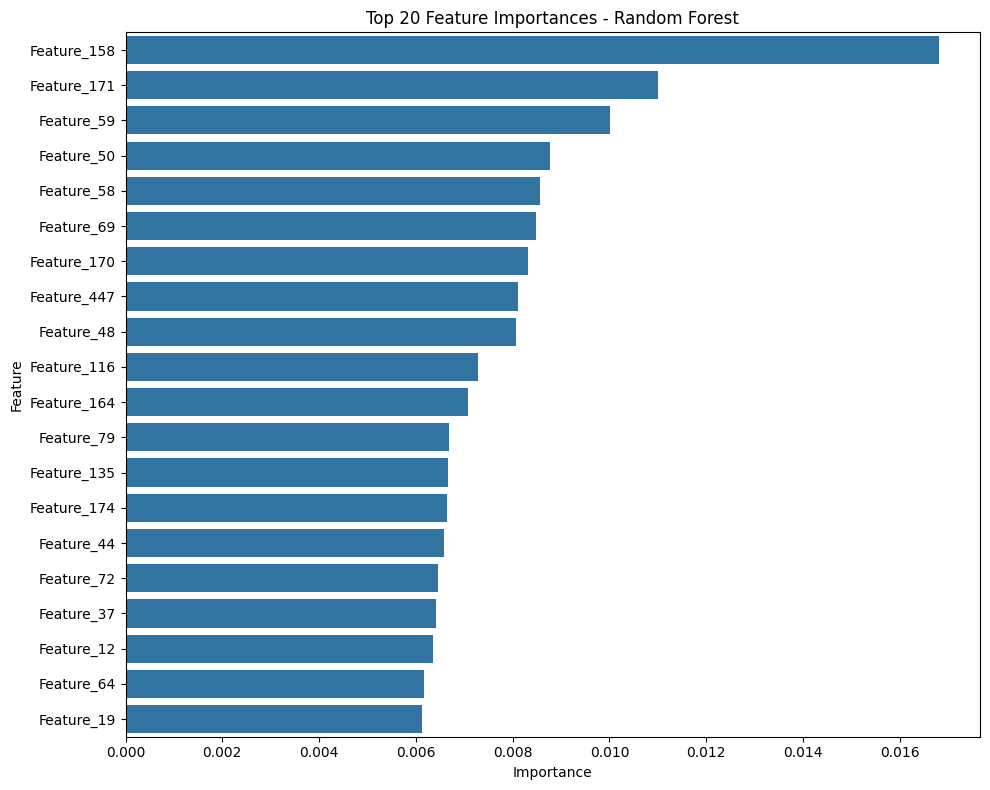

In [39]:
# Model 1: Random Forest Regressor with Cross-Validation
print("\n" + "="*50)
print("Random Forest Regressor")
print("="*50)

# Define model with optimized hyperparameters
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=0.33,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

# Evaluate with cross-validation
rf_results = evaluate_model_cv(rf, X_scaled, y, "Random Forest")

# Plot feature importance
if hasattr(rf, 'feature_importances_'):
    feature_importance = rf.feature_importances_
    # Create DataFrame for plotting
    feature_df = pd.DataFrame({
        'Feature': [f'Feature_{i+1}' for i in range(len(feature_importance))],
        'Importance': feature_importance
    })
    # Sort by importance
    feature_df = feature_df.sort_values('Importance', ascending=False).head(20)
    
    plt.figure(figsize=(10, 8))
    plt.title('Top 20 Feature Importances - Random Forest')
    sns.barplot(x='Importance', y='Feature', data=feature_df)
    plt.tight_layout()
    plt.show()


Gradient Boosting Regressor

Performing 5-fold cross-validation for Gradient Boosting...
Cross-validation R² scores: [ 0.13680004  0.14950314  0.24648681 -0.00040234  0.17120302]
Mean CV R² score: 0.1407
Standard deviation: 0.0802

Gradient Boosting Performance (using cross-validated predictions):
R² Score (log scale): 0.1467
RMSE (log scale): 2.7271
MAE (log scale): 2.1160

Original Scale Performance:
R² Score: 0.0925
RMSE: 12463.12
MAE: 3158.36


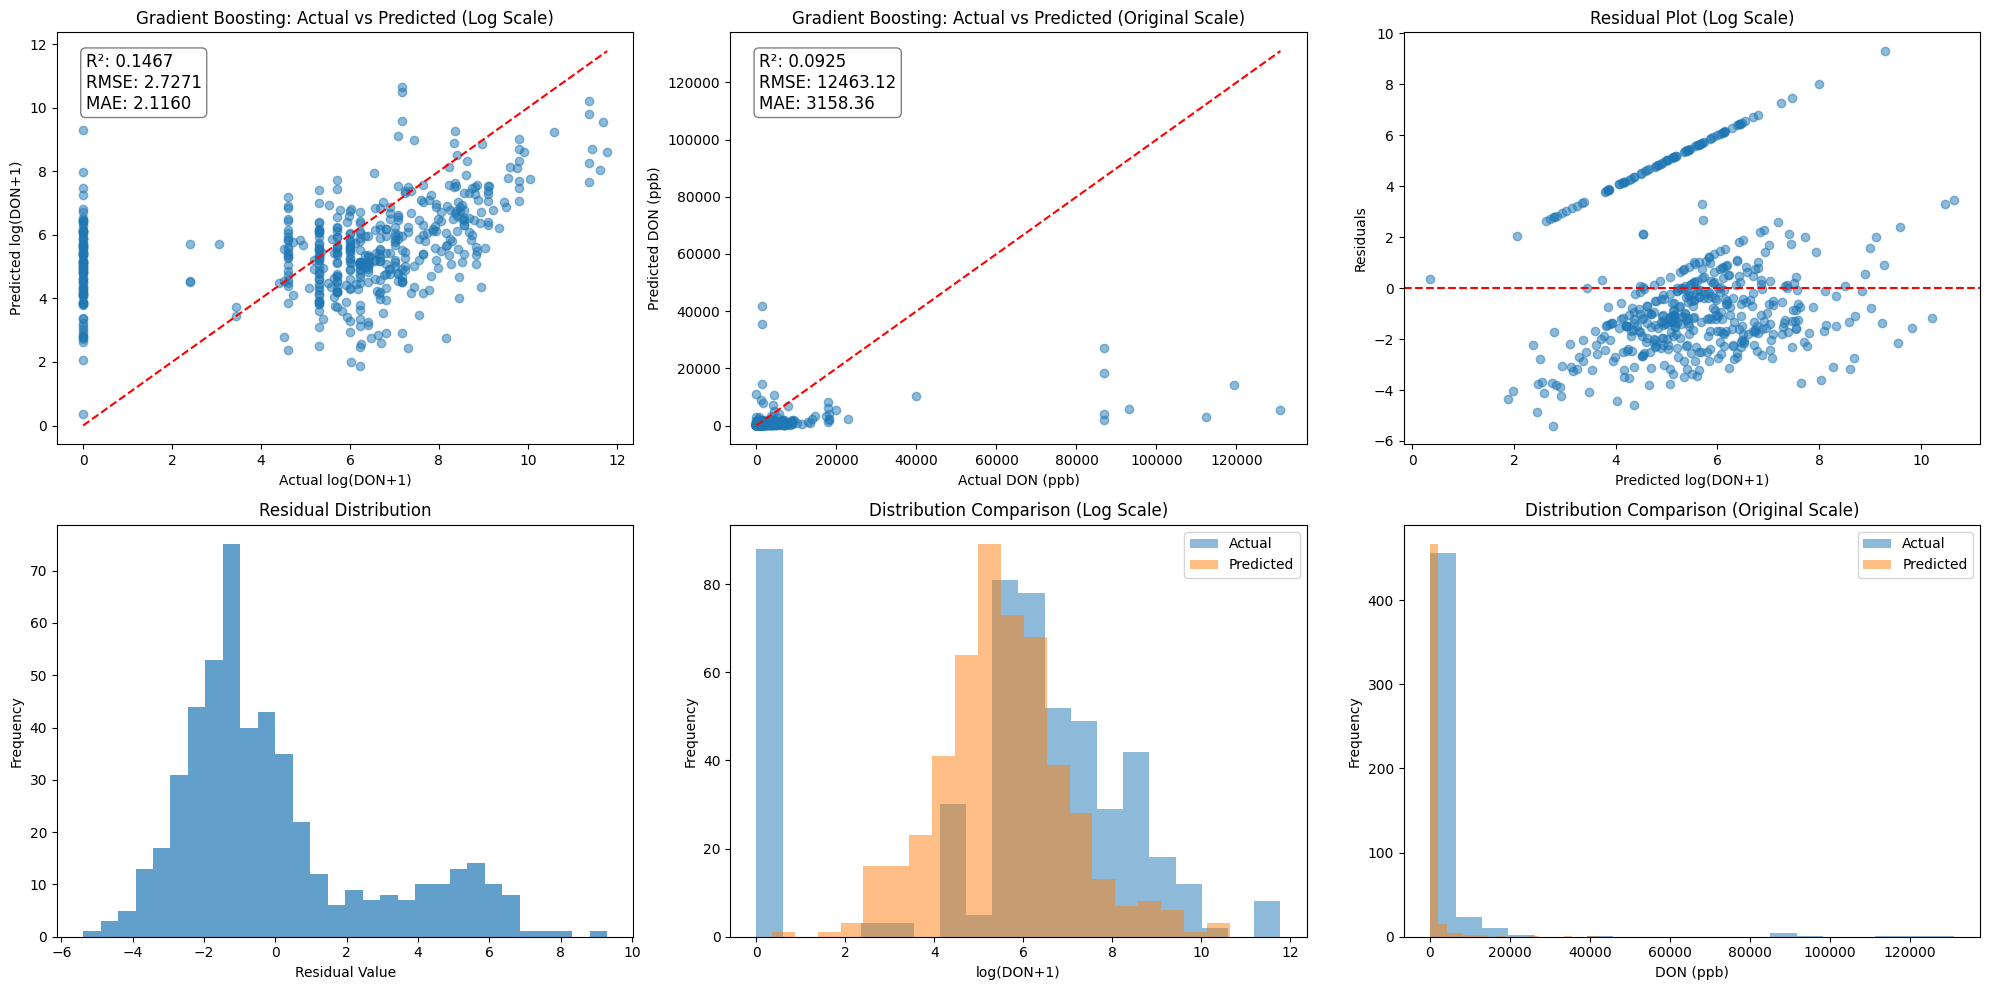

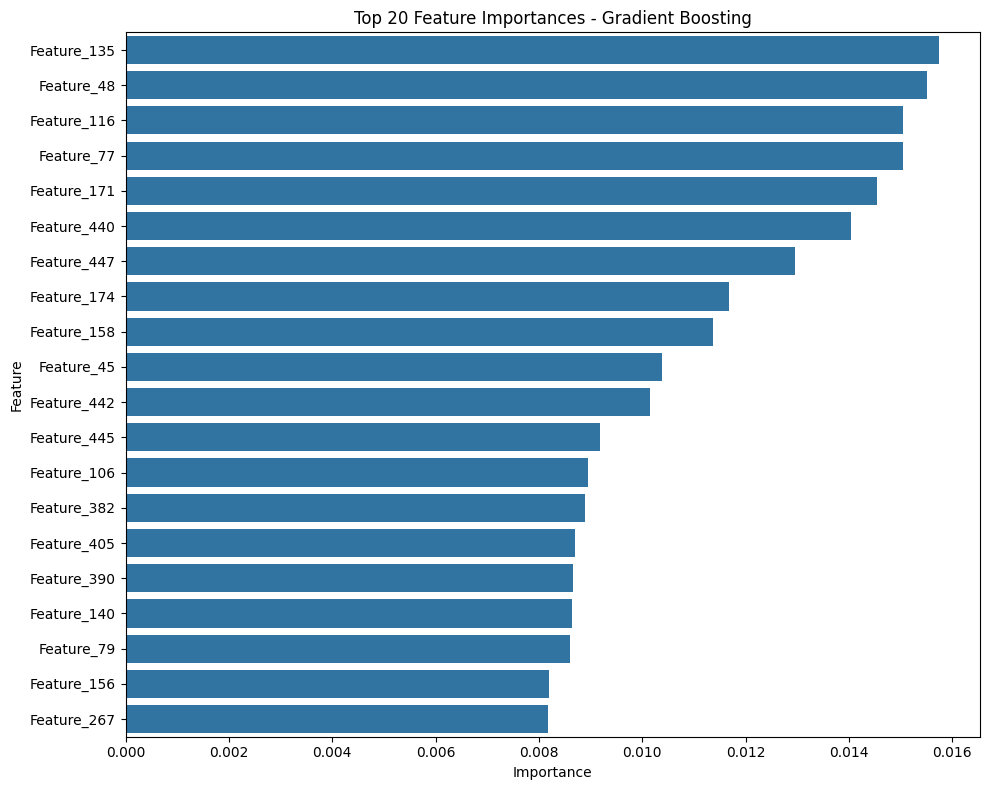

In [40]:
# Model 2: Gradient Boosting Regressor with Cross-Validation
print("\n" + "="*50)
print("Gradient Boosting Regressor")
print("="*50)

# Define model with optimized hyperparameters
gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=0.5,
    random_state=42
)

# Evaluate with cross-validation
gb_results = evaluate_model_cv(gb, X_scaled, y, "Gradient Boosting")

# Plot feature importance
if hasattr(gb, 'feature_importances_'):
    feature_importance = gb.feature_importances_
    # Create DataFrame for plotting
    feature_df = pd.DataFrame({
        'Feature': [f'Feature_{i+1}' for i in range(len(feature_importance))],
        'Importance': feature_importance
    })
    # Sort by importance
    feature_df = feature_df.sort_values('Importance', ascending=False).head(20)
    
    plt.figure(figsize=(10, 8))
    plt.title('Top 20 Feature Importances - Gradient Boosting')
    sns.barplot(x='Importance', y='Feature', data=feature_df)
    plt.tight_layout()
    plt.show()


XGBoost Regressor

Performing 5-fold cross-validation for XGBoost...
Cross-validation R² scores: [0.09779687 0.12817781 0.24049545 0.02668301 0.13940693]
Mean CV R² score: 0.1265
Standard deviation: 0.0692

XGBoost Performance (using cross-validated predictions):
R² Score (log scale): 0.1318
RMSE (log scale): 2.7507
MAE (log scale): 2.1358

Original Scale Performance:
R² Score: 0.1410
RMSE: 12125.62
MAE: 3141.94


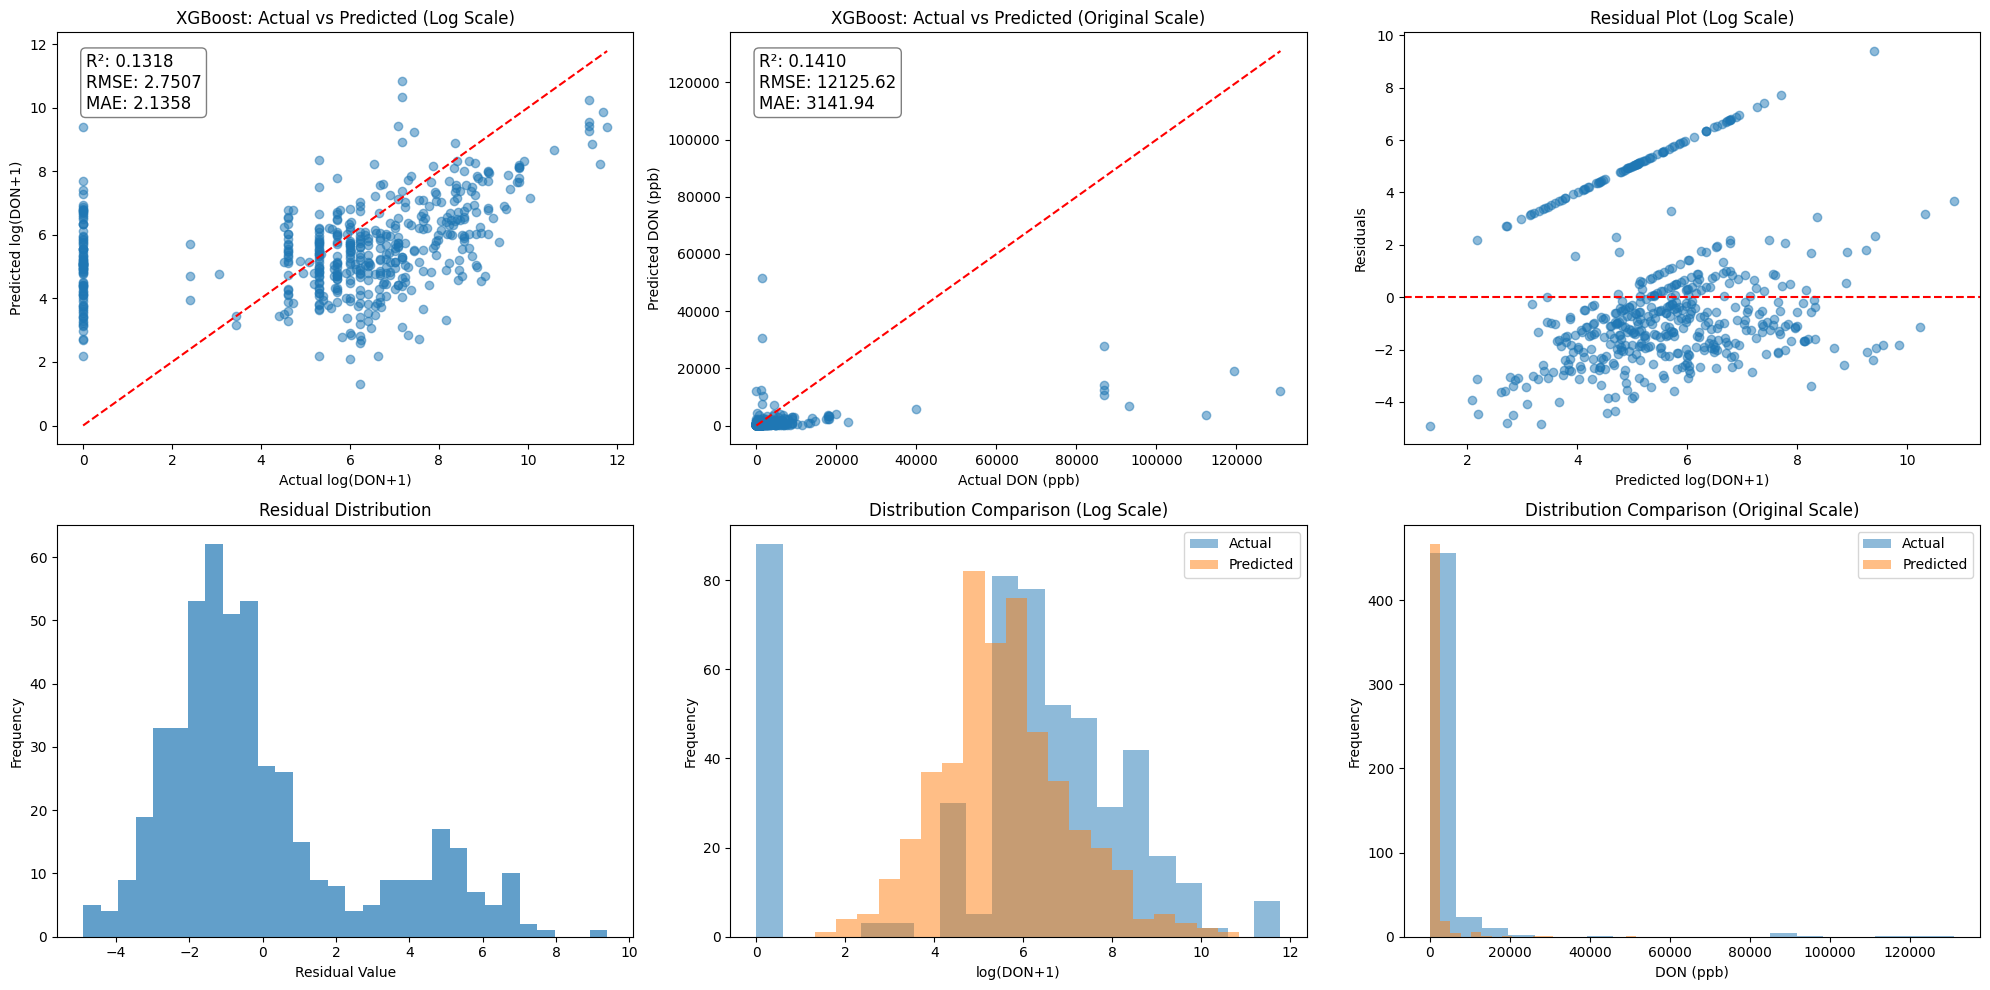

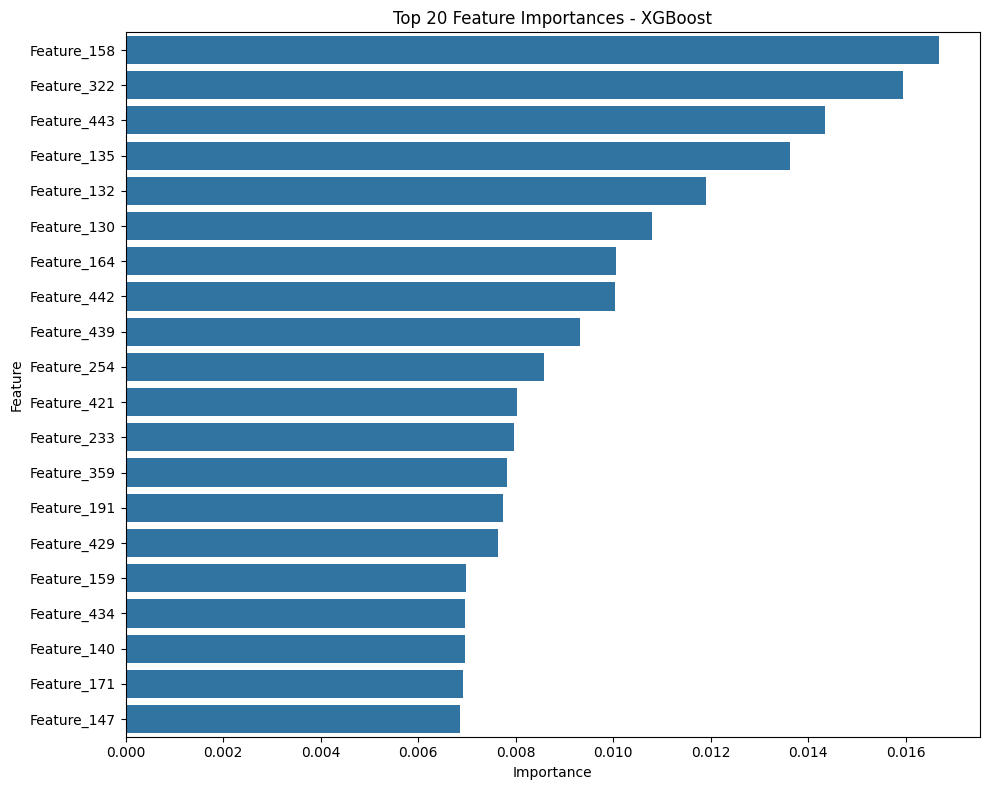

In [41]:
# Model 3: XGBoost Regressor with Cross-Validation
print("\n" + "="*50)
print("XGBoost Regressor")
print("="*50)

# Define model with optimized hyperparameters
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

# Evaluate with cross-validation
xgb_results = evaluate_model_cv(xgb, X_scaled, y, "XGBoost")

# Plot feature importance
if hasattr(xgb, 'feature_importances_'):
    feature_importance = xgb.feature_importances_
    # Create DataFrame for plotting
    feature_df = pd.DataFrame({
        'Feature': [f'Feature_{i+1}' for i in range(len(feature_importance))],
        'Importance': feature_importance
    })
    # Sort by importance
    feature_df = feature_df.sort_values('Importance', ascending=False).head(20)
    
    plt.figure(figsize=(10, 8))
    plt.title('Top 20 Feature Importances - XGBoost')
    sns.barplot(x='Importance', y='Feature', data=feature_df)
    plt.tight_layout()
    plt.show()


LightGBM Regressor

Performing 5-fold cross-validation for LightGBM...
Cross-validation R² scores: [ 0.1554996   0.09003054  0.27252073 -0.00375066  0.16110131]
Mean CV R² score: 0.1351
Standard deviation: 0.0909

LightGBM Performance (using cross-validated predictions):
R² Score (log scale): 0.1412
RMSE (log scale): 2.7358
MAE (log scale): 2.1102

Original Scale Performance:
R² Score: 0.1269
RMSE: 12224.67
MAE: 3105.83


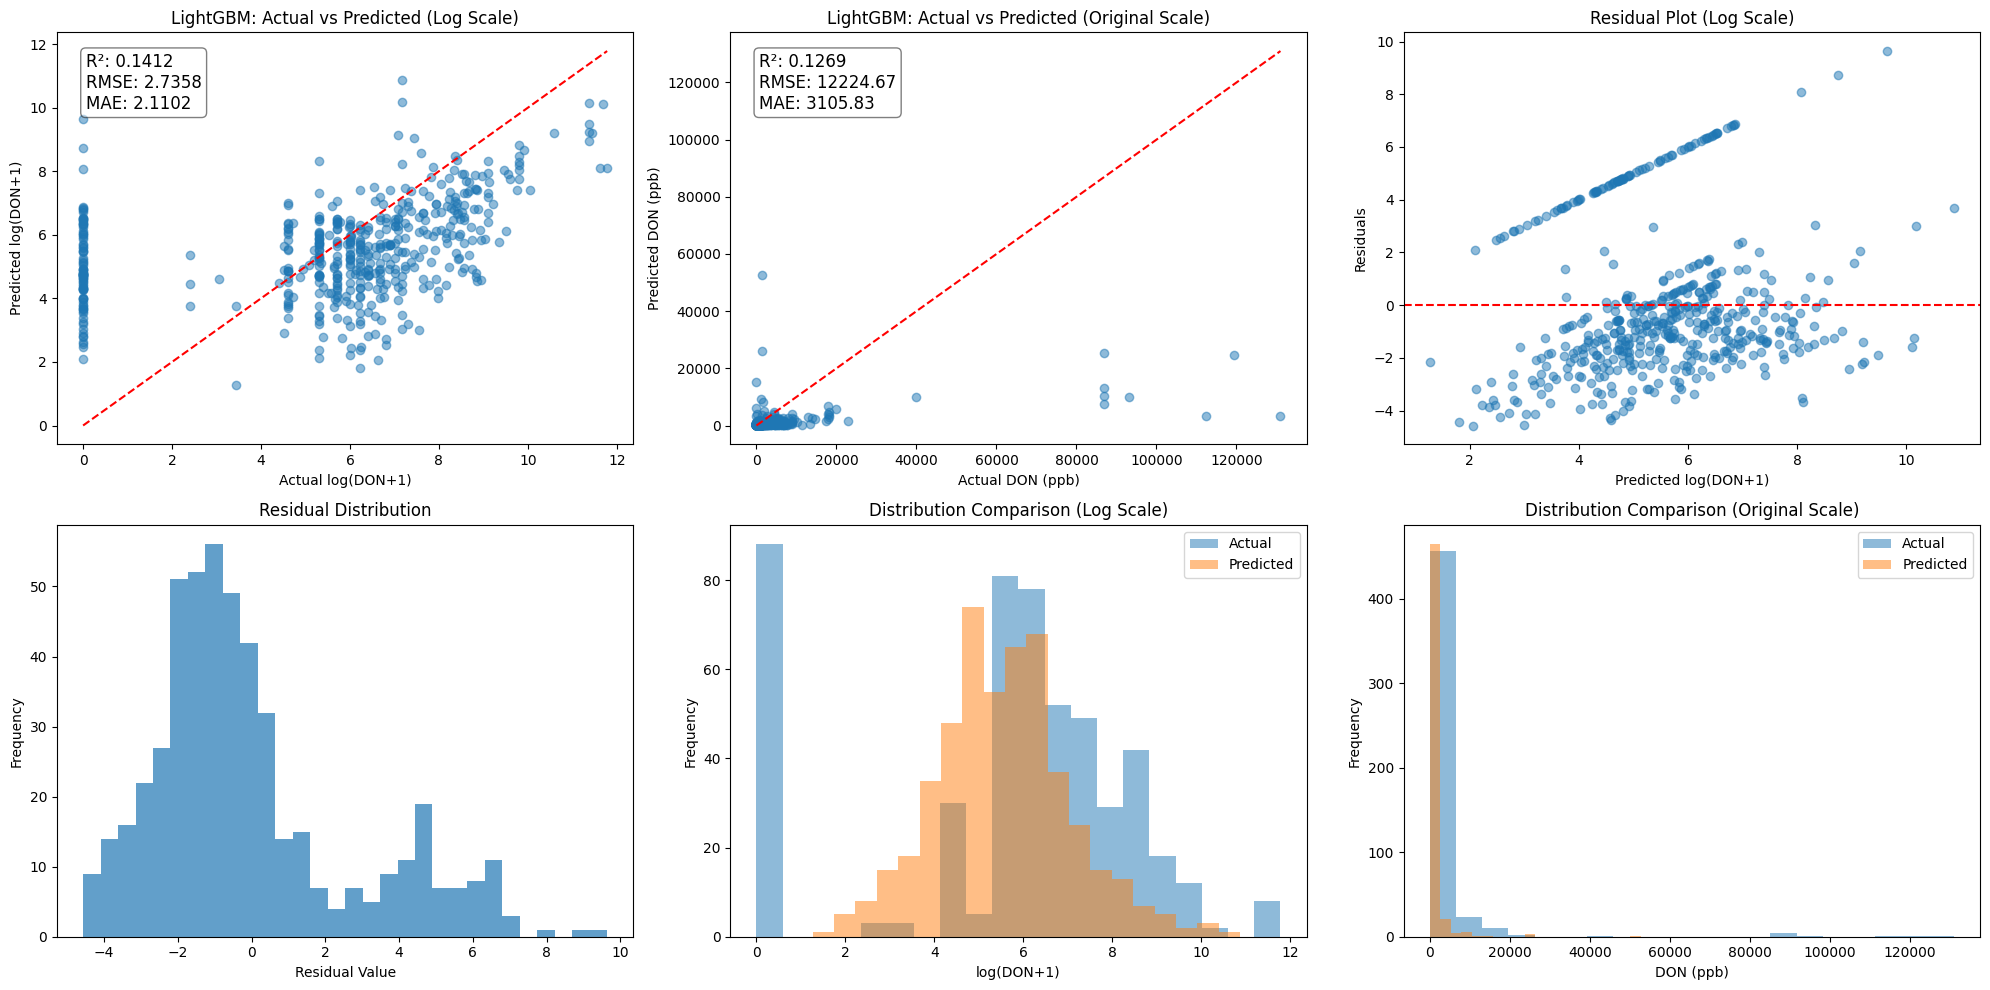

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74649
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 447
[LightGBM] [Info] Start training from score 5.597026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

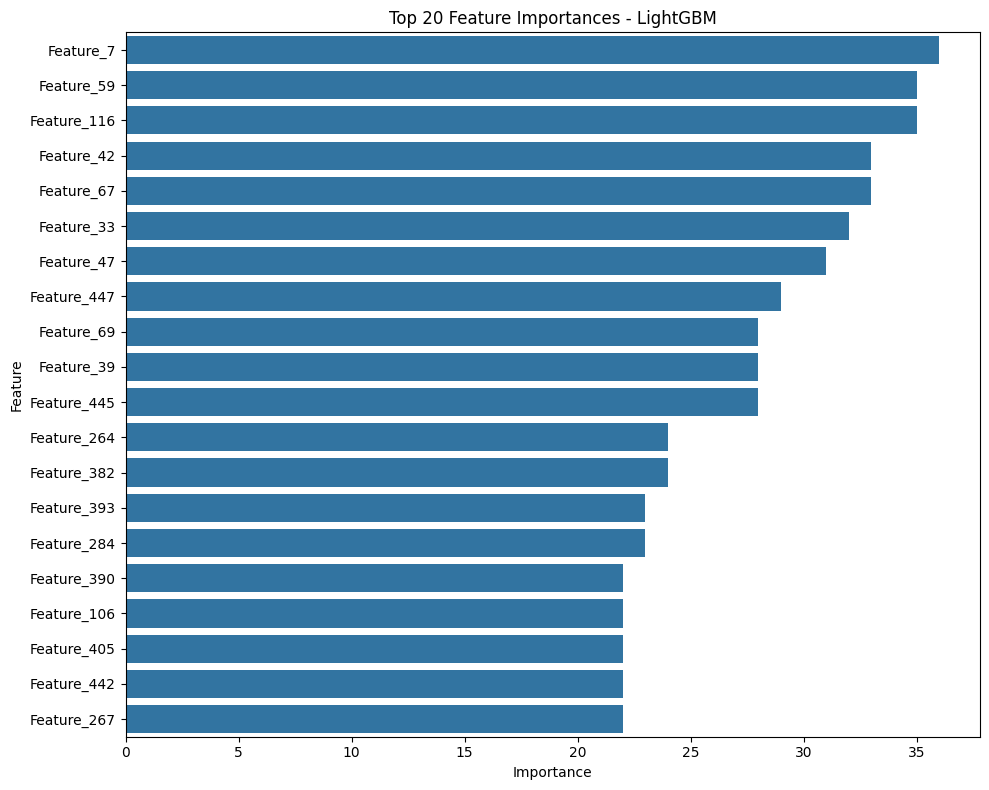

In [42]:
# Model 4: LightGBM Regressor with Cross-Validation
print("\n" + "="*50)
print("LightGBM Regressor")
print("="*50)

# Define model with optimized hyperparameters
lgbm = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=5,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

# Evaluate with cross-validation
lgbm_results = evaluate_model_cv(lgbm, X_scaled, y, "LightGBM")

# Plot feature importance
if hasattr(lgbm, 'feature_importances_'):
    feature_importance = lgbm.feature_importances_
    # Create DataFrame for plotting
    feature_df = pd.DataFrame({
        'Feature': [f'Feature_{i+1}' for i in range(len(feature_importance))],
        'Importance': feature_importance
    })
    # Sort by importance
    feature_df = feature_df.sort_values('Importance', ascending=False).head(20)
    
    plt.figure(figsize=(10, 8))
    plt.title('Top 20 Feature Importances - LightGBM')
    sns.barplot(x='Importance', y='Feature', data=feature_df)
    plt.tight_layout()
    plt.show()


Voting Ensemble Regressor
Model weights for voting ensemble:
- Random Forest: 0.3005
- Gradient Boosting: 0.2447
- XGBoost: 0.2200
- LightGBM: 0.2349

Performing 5-fold cross-validation for Voting Ensemble...
Cross-validation R² scores: [0.13790627 0.13263945 0.26046239 0.07382806 0.18416759]
Mean CV R² score: 0.1578
Standard deviation: 0.0622

Voting Ensemble Performance (using cross-validated predictions):
R² Score (log scale): 0.1636
RMSE (log scale): 2.6999
MAE (log scale): 2.0909

Original Scale Performance:
R² Score: 0.1192
RMSE: 12278.51
MAE: 3082.56


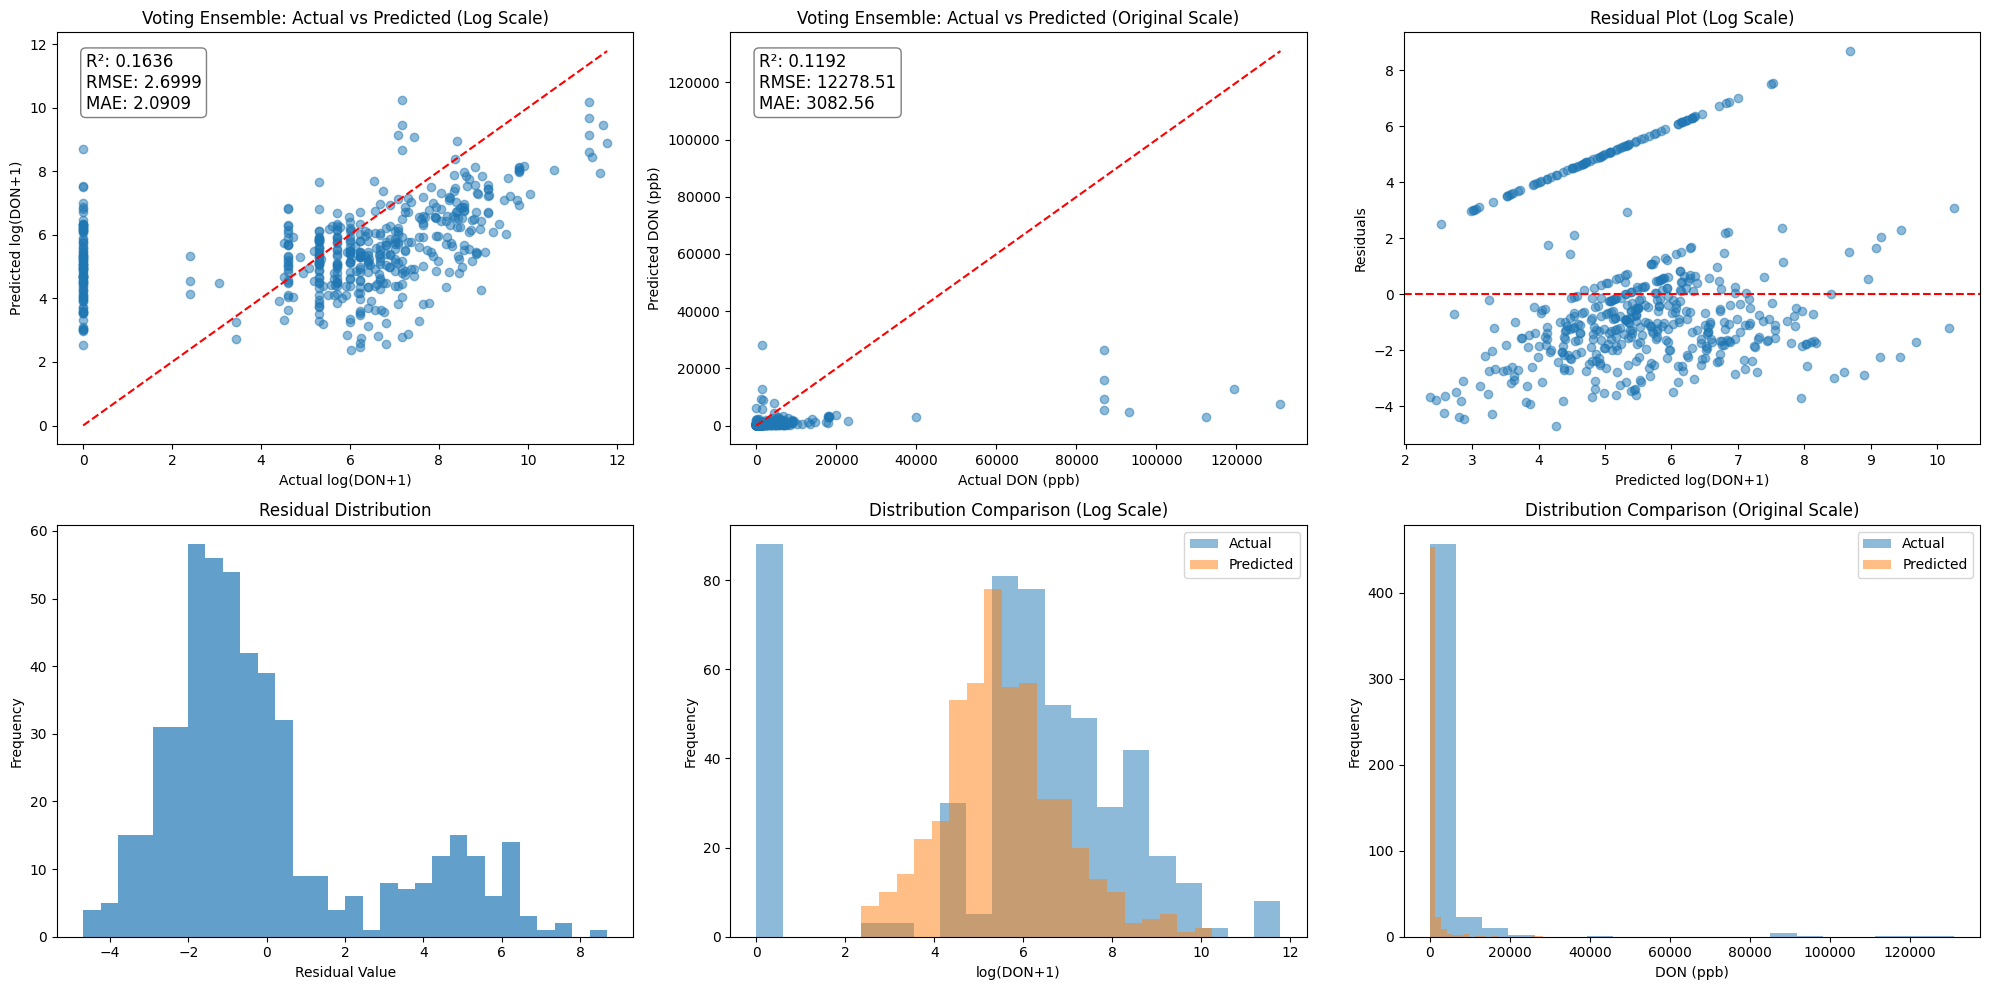

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74649
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 447
[LightGBM] [Info] Start training from score 5.597026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [43]:
# Voting Ensemble with Cross-Validation
print("\n" + "="*50)
print("Voting Ensemble Regressor")
print("="*50)

# Create base models for the ensemble
rf_base = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42, n_jobs=-1)
gb_base = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
xgb_base = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
lgbm_base = LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)

# Create weights based on individual model performance
all_cv_scores = {
    'Random Forest': rf_results['mean_cv_r2'],
    'Gradient Boosting': gb_results['mean_cv_r2'],
    'XGBoost': xgb_results['mean_cv_r2'],
    'LightGBM': lgbm_results['mean_cv_r2']
}

# Get positive weights even if some R² values are negative
model_weights = {name: max(0.1, score) for name, score in all_cv_scores.items()}
total = sum(model_weights.values())
model_weights = {name: weight/total for name, weight in model_weights.items()}

print("Model weights for voting ensemble:")
for name, weight in model_weights.items():
    print(f"- {name}: {weight:.4f}")

# Create voting ensemble
voting = VotingRegressor(
    estimators=[
        ('rf', rf_base),
        ('gb', gb_base),
        ('xgb', xgb_base),
        ('lgbm', lgbm_base)
    ],
    weights=[
        model_weights['Random Forest'],
        model_weights['Gradient Boosting'],
        model_weights['XGBoost'],
        model_weights['LightGBM']
    ]
)

# Evaluate with cross-validation
voting_results = evaluate_model_cv(voting, X_scaled, y, "Voting Ensemble")


Model Comparison Based on Cross-Validation
Models ranked by R² in original scale:
               Model  R² (original)  RMSE (original)  MAE (original)
0            XGBoost       0.140960     12125.623738     3141.942048
1           LightGBM       0.126869     12224.669075     3105.825046
2    Voting Ensemble       0.119161     12278.508745     3082.556480
3  Gradient Boosting       0.092475     12463.116674     3158.356999
4      Random Forest       0.065873     12644.465856     3122.673185

Models ranked by mean cross-validation R² score:
               Model  Mean CV R²  CV R² Std Dev
0      Random Forest    0.172795       0.058801
1    Voting Ensemble    0.157801       0.062153
2  Gradient Boosting    0.140718       0.080155
3           LightGBM    0.135080       0.090871
4            XGBoost    0.126512       0.069212


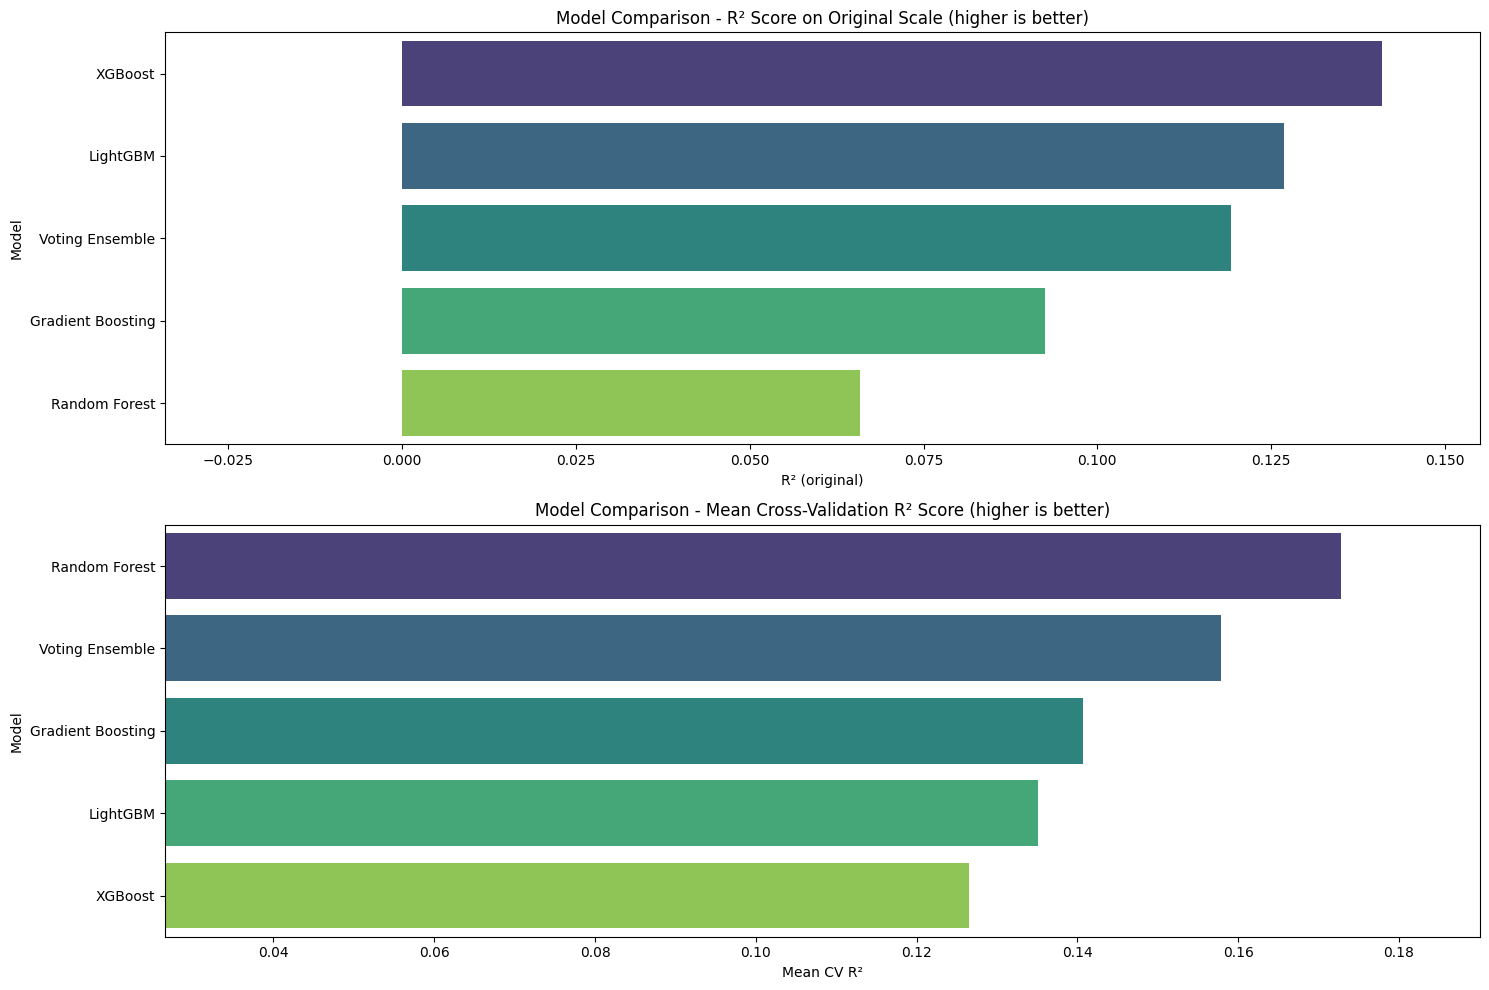


Best Model (by R² on original scale):
Model: XGBoost
Mean CV R²: 0.1265
R² Score (original): 0.1410
RMSE (original): 12125.62
MAE (original): 3141.94

Best Model (by mean CV R²):
Model: Random Forest
Mean CV R²: 0.1728
R² Score (original): 0.0659
RMSE (original): 12644.47
MAE (original): 3122.67


In [45]:
# Compare all models
print("\n" + "="*50)
print("Model Comparison Based on Cross-Validation")
print("="*50)

# Gather results
all_results = [rf_results, gb_results, xgb_results, lgbm_results, voting_results]

# Create comparison DataFrame for CV results
cv_comparison = pd.DataFrame([
    {
        'Model': result['model_name'],
        'Mean CV R²': result['mean_cv_r2'],
        'CV R² Std Dev': result['cv_scores'].std(),
        'R² (log scale)': result['r2'],
        'R² (original)': result['r2_orig'],
        'RMSE (original)': result['rmse_orig'],
        'MAE (original)': result['mae_orig']
    }
    for result in all_results
])

# Sort by R² on original scale
cv_comparison = cv_comparison.sort_values('R² (original)', ascending=False).reset_index(drop=True)
print("Models ranked by R² in original scale:")
print(cv_comparison[['Model', 'R² (original)', 'RMSE (original)', 'MAE (original)']])

print("\nModels ranked by mean cross-validation R² score:")
cv_comparison_by_cv = cv_comparison.sort_values('Mean CV R²', ascending=False).reset_index(drop=True)
print(cv_comparison_by_cv[['Model', 'Mean CV R²', 'CV R² Std Dev']])

# Plot comparison
plt.figure(figsize=(15, 10))

# R² comparison (higher is better)
plt.subplot(2, 1, 1)
sns.barplot(x='R² (original)', y='Model', data=cv_comparison, palette='viridis')
plt.title('Model Comparison - R² Score on Original Scale (higher is better)')
plt.xlim(max(min(cv_comparison['R² (original)']) - 0.1, -0.2), max(cv_comparison['R² (original)']) * 1.1)

# Mean CV R² comparison
plt.subplot(2, 1, 2)
sns.barplot(x='Mean CV R²', y='Model', data=cv_comparison_by_cv, palette='viridis')
plt.title('Model Comparison - Mean Cross-Validation R² Score (higher is better)')
plt.xlim(max(min(cv_comparison_by_cv['Mean CV R²']) - 0.1, -0.2), max(cv_comparison_by_cv['Mean CV R²']) * 1.1)

plt.tight_layout()
plt.show()

# Highlight best model
best_model_row = cv_comparison.iloc[0]
print("\nBest Model (by R² on original scale):")
print(f"Model: {best_model_row['Model']}")
print(f"Mean CV R²: {best_model_row['Mean CV R²']:.4f}")
print(f"R² Score (original): {best_model_row['R² (original)']:.4f}")
print(f"RMSE (original): {best_model_row['RMSE (original)']:.2f}")
print(f"MAE (original): {best_model_row['MAE (original)']:.2f}")

# Highlight best model by CV score
best_model_cv = cv_comparison_by_cv.iloc[0]
print("\nBest Model (by mean CV R²):")
print(f"Model: {best_model_cv['Model']}")
print(f"Mean CV R²: {best_model_cv['Mean CV R²']:.4f}")
print(f"R² Score (original): {best_model_cv['R² (original)']:.4f}")
print(f"RMSE (original): {best_model_cv['RMSE (original)']:.2f}")
print(f"MAE (original): {best_model_cv['MAE (original)']:.2f}")

Original X shape: (500, 447)
Original y shape: (500,)

Creating derivative features...
Combined features shape: (500, 901)

Selecting best features...
Selected 150 features using mutual information
Selected 150 features using F-regression

Evaluating optimized models...

Performing 5-fold cross-validation for XGBoost (MI Features)...
Cross-validation R² scores: [0.0247411  0.16502181 0.25818211 0.03994677 0.16921551]
Mean CV R² score: 0.1314
Standard deviation: 0.0876

XGBoost (MI Features) Performance (using cross-validated predictions):
R² Score (log scale): 0.1424
RMSE (log scale): 2.7339
MAE (log scale): 2.0910

Original Scale Performance:
R² Score: 0.0917
RMSE: 12468.76
MAE: 3126.40


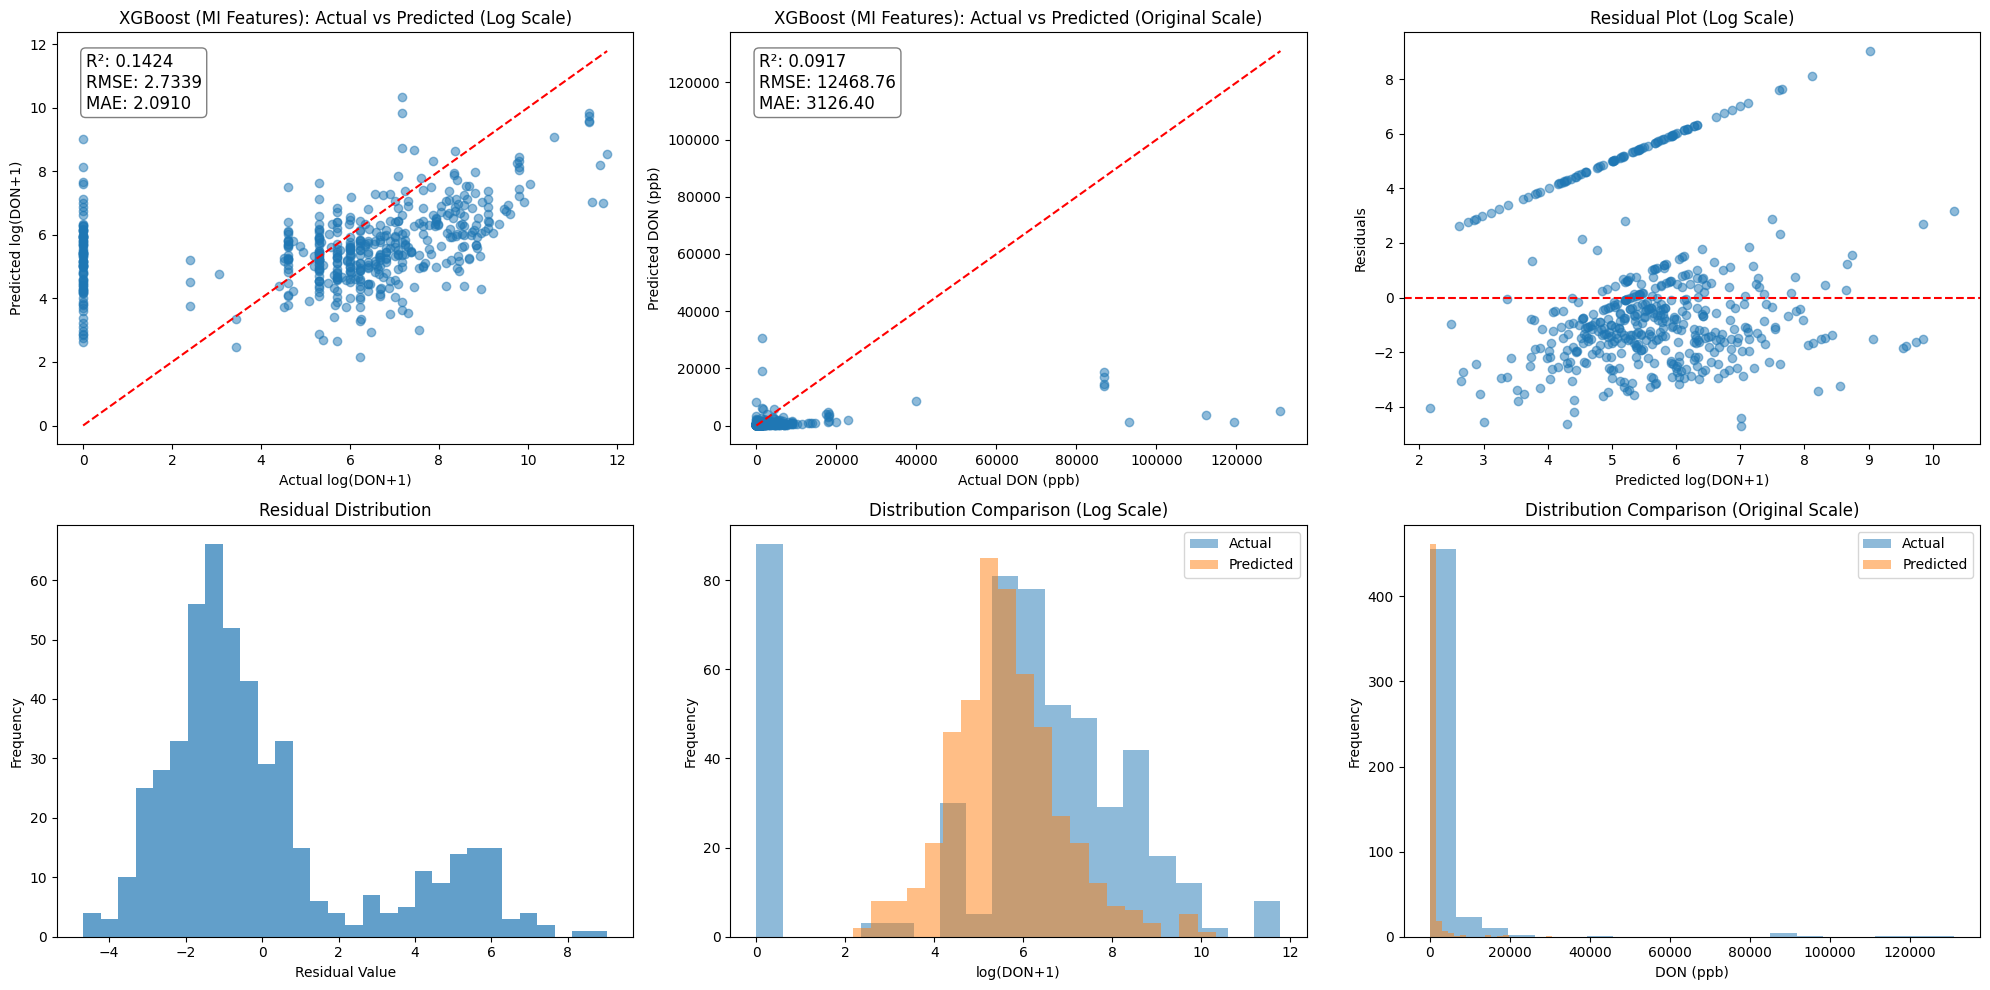


Performing 5-fold cross-validation for Gradient Boosting (F Features)...
Cross-validation R² scores: [-0.01173237  0.16938575  0.18130534  0.01431991  0.12274536]
Mean CV R² score: 0.0952
Standard deviation: 0.0796

Gradient Boosting (F Features) Performance (using cross-validated predictions):
R² Score (log scale): 0.1051
RMSE (log scale): 2.7926
MAE (log scale): 2.1690

Original Scale Performance:
R² Score: 0.0450
RMSE: 12784.83
MAE: 3190.60


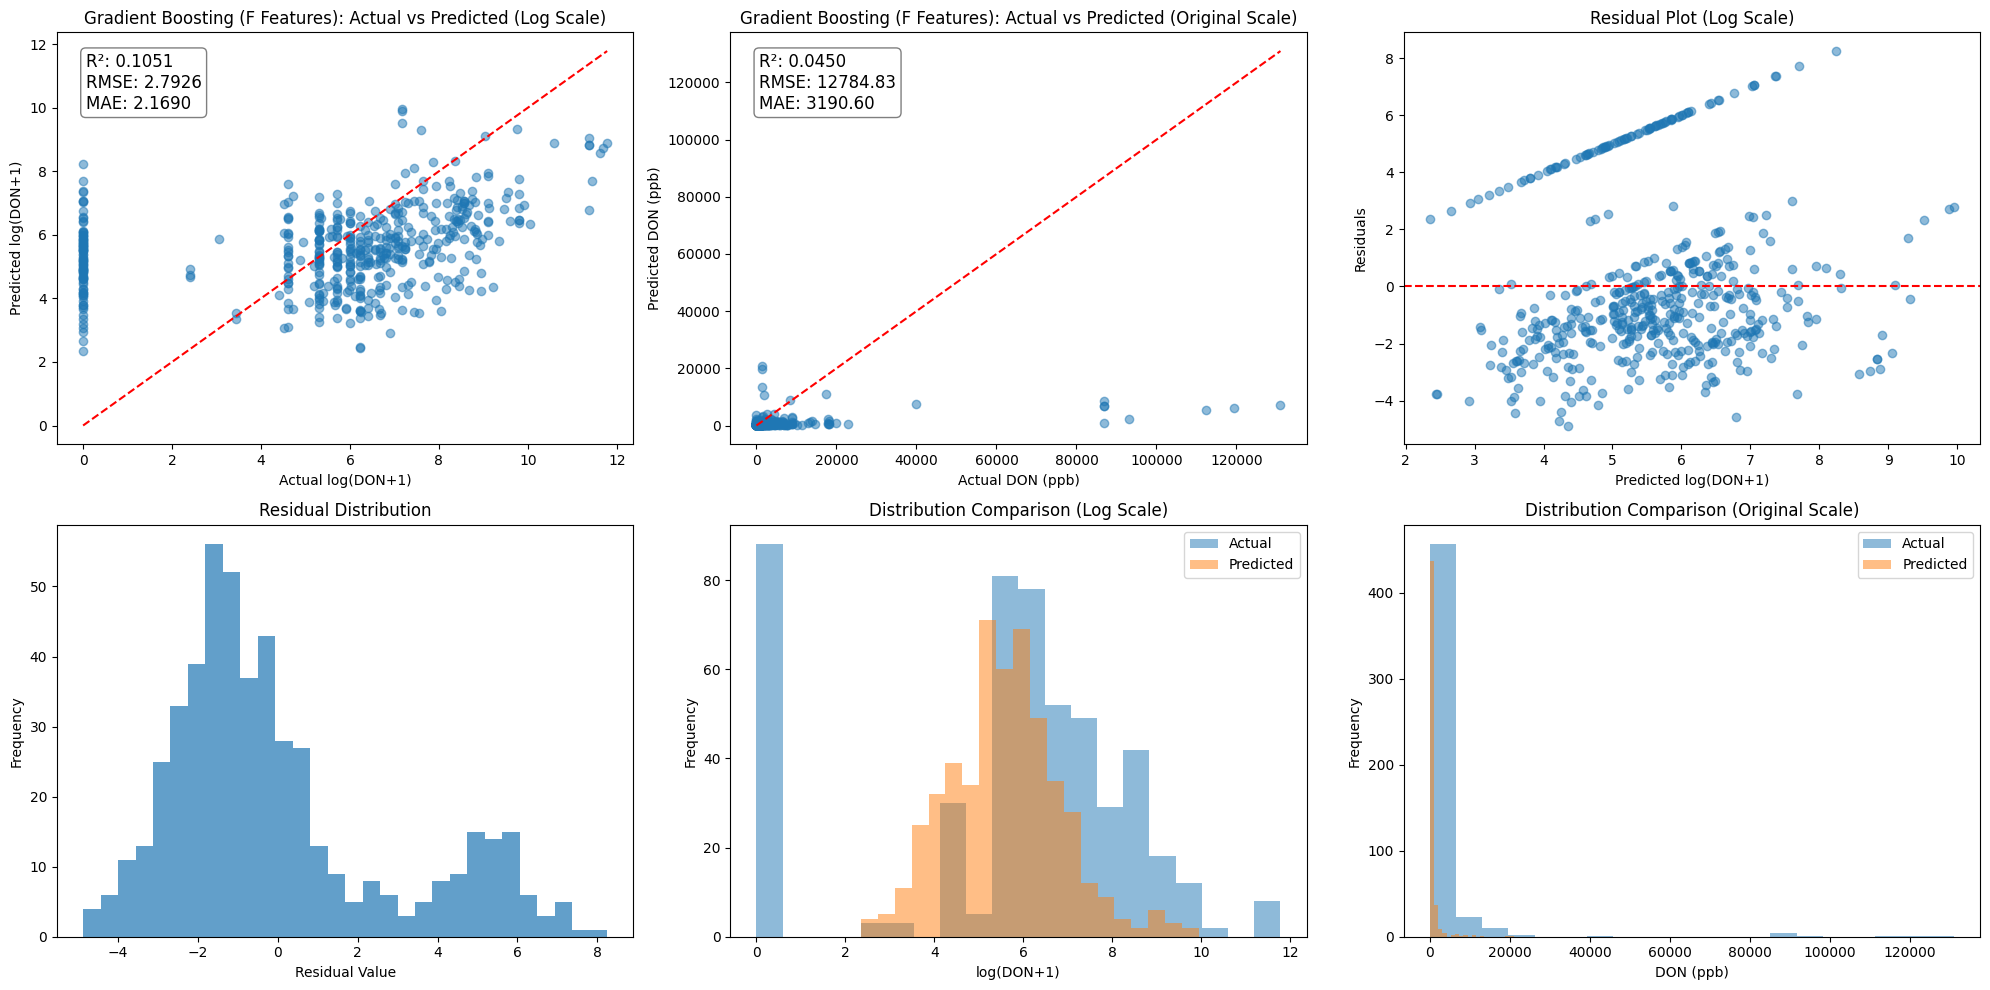


Performing 5-fold cross-validation for SVR (MI Features)...
Cross-validation R² scores: [0.04144881 0.11723538 0.14696724 0.17475233 0.15356043]
Mean CV R² score: 0.1268
Standard deviation: 0.0465

SVR (MI Features) Performance (using cross-validated predictions):
R² Score (log scale): 0.1286
RMSE (log scale): 2.7558
MAE (log scale): 1.8791

Original Scale Performance:
R² Score: 0.0631
RMSE: 12663.25
MAE: 3044.49


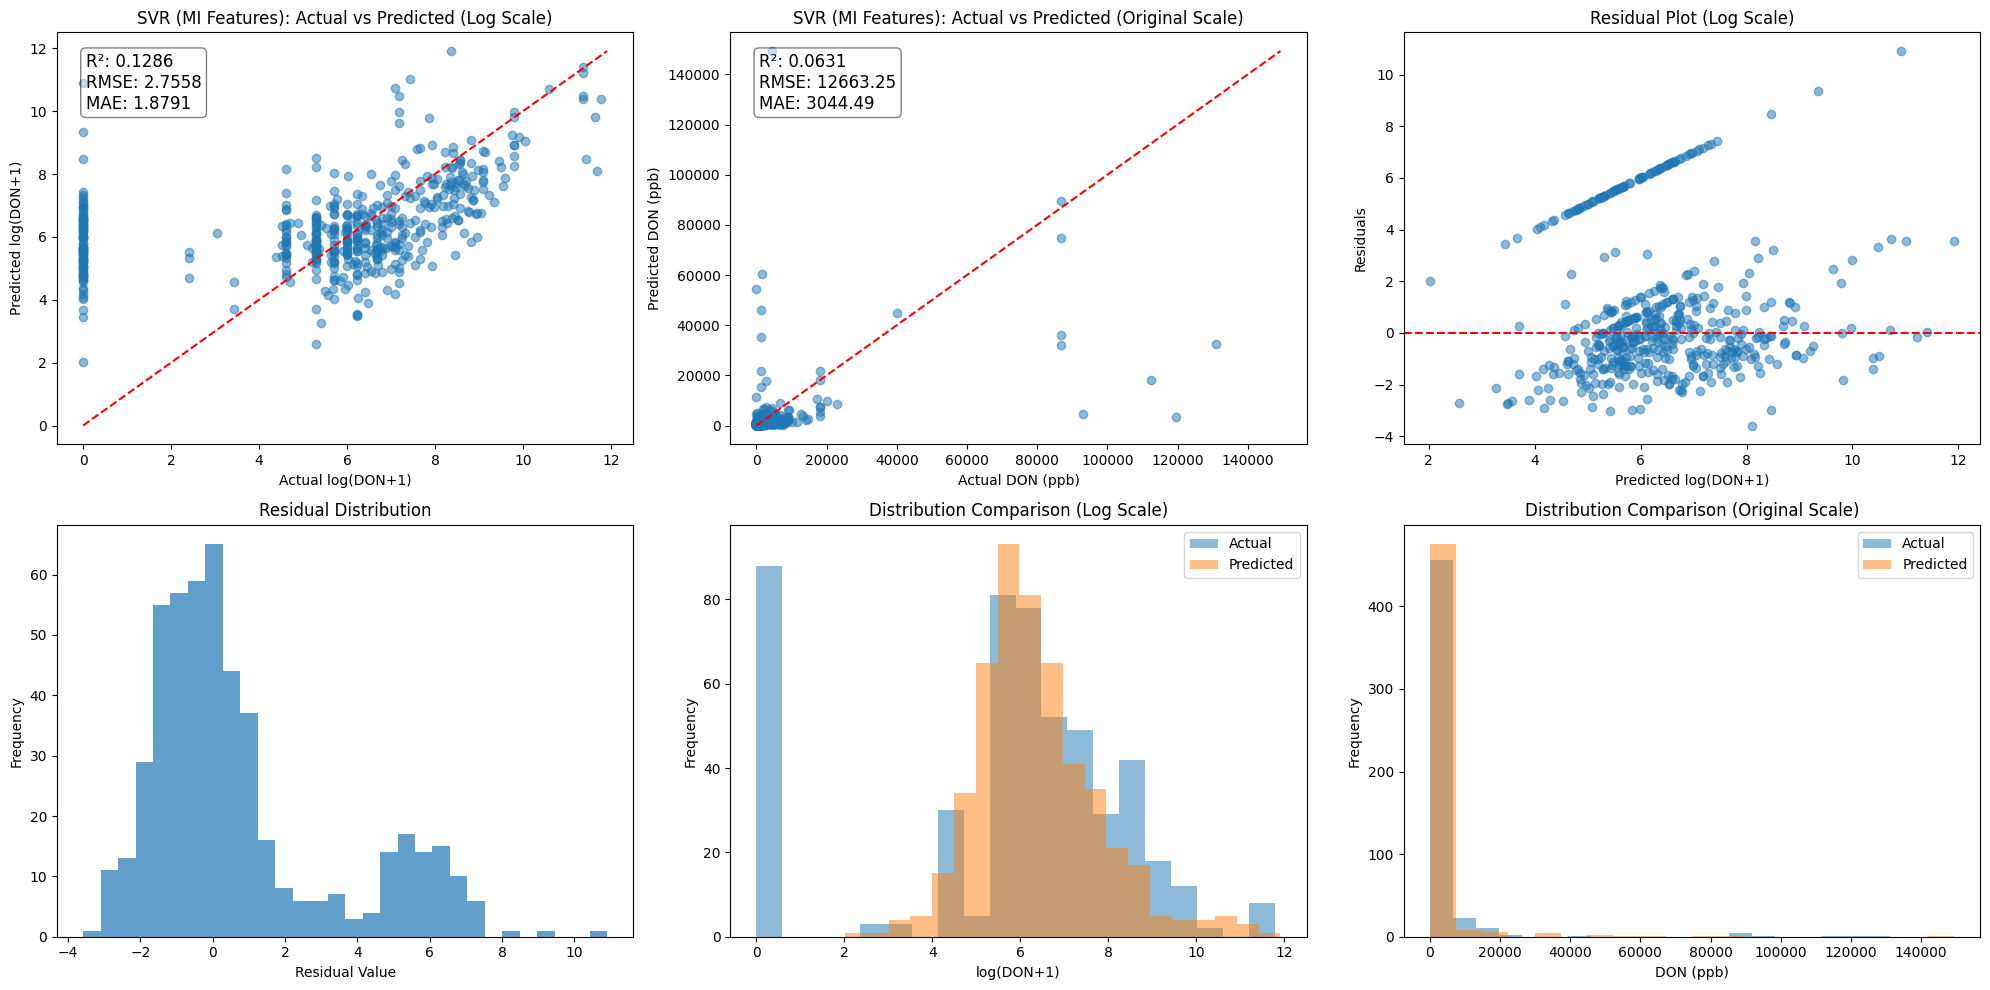


Performing 5-fold cross-validation for Kernel Ridge (F Features)...
Cross-validation R² scores: [-0.21198026 -0.09619531  0.0166556  -0.14533318 -0.10218864]
Mean CV R² score: -0.1078
Standard deviation: 0.0747

Kernel Ridge (F Features) Performance (using cross-validated predictions):
R² Score (log scale): -0.0988
RMSE (log scale): 3.0945
MAE (log scale): 2.4462

Original Scale Performance:
R² Score: -0.0355
RMSE: 13312.92
MAE: 3200.56


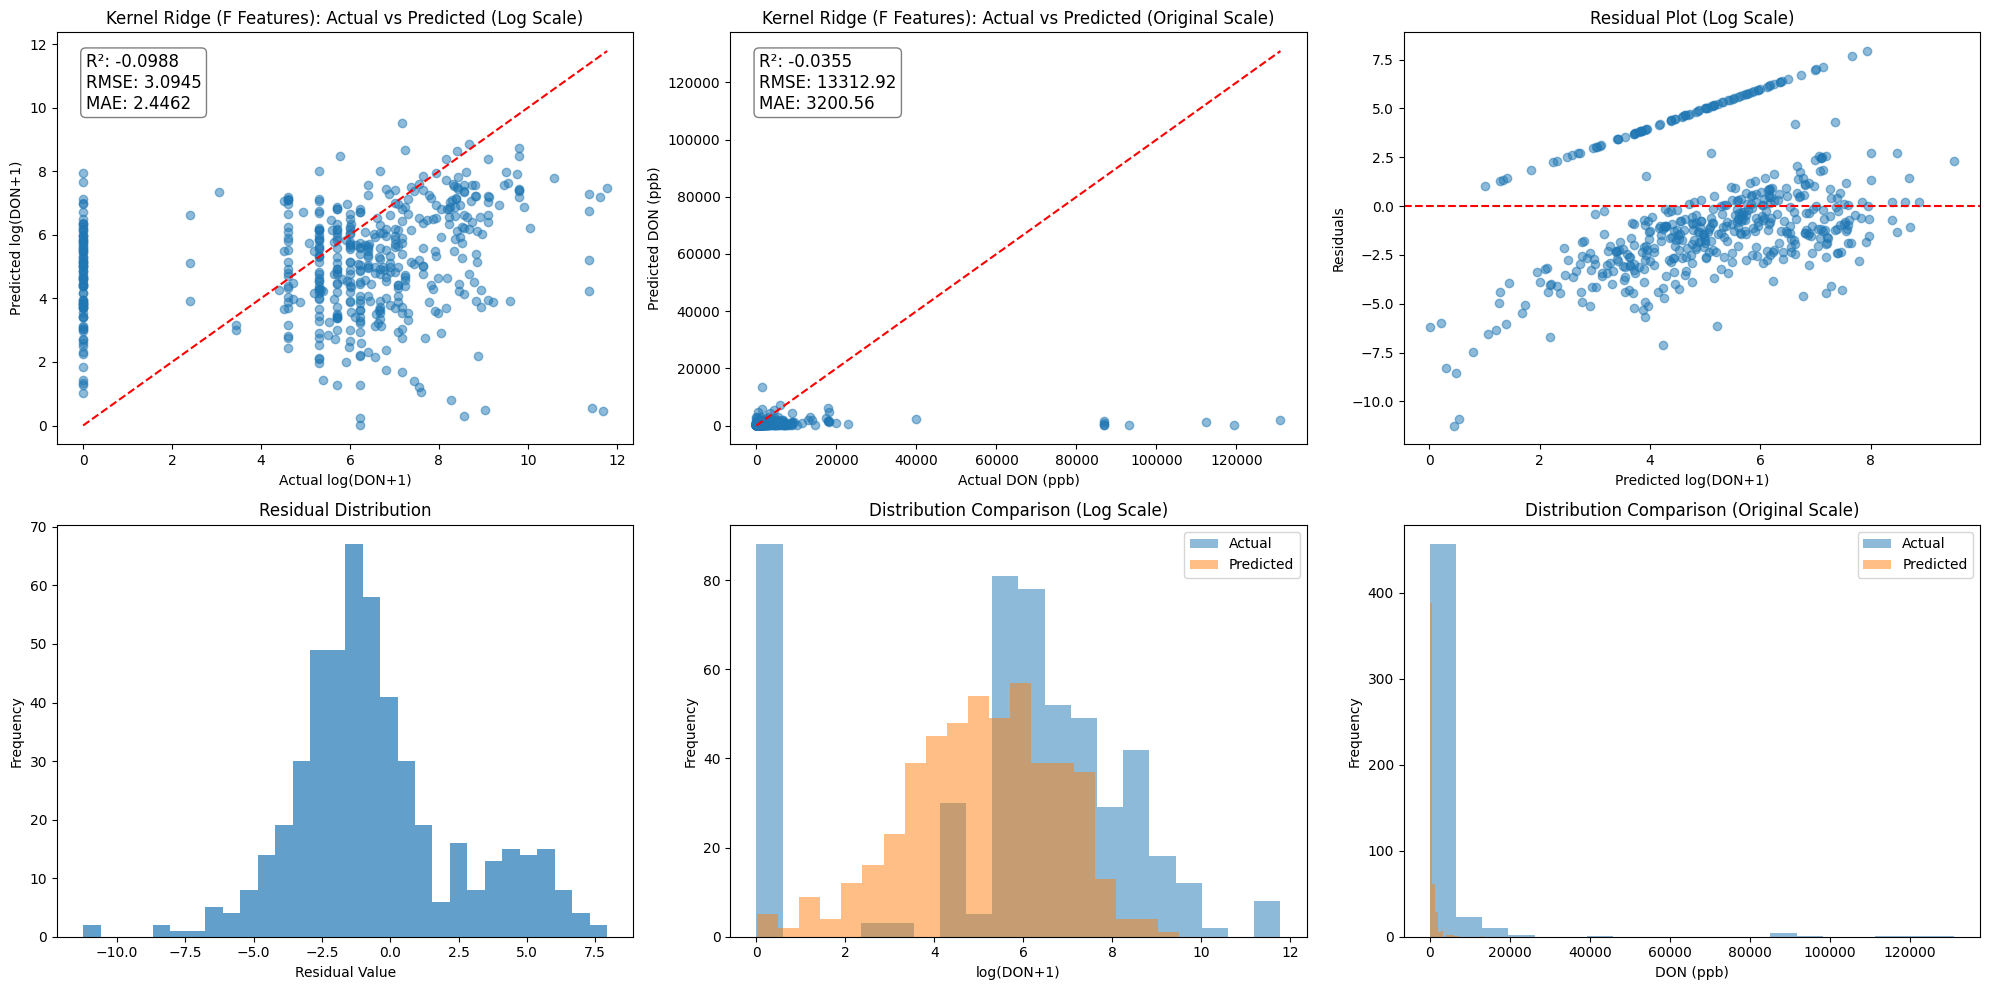


Performing 5-fold cross-validation for Random Forest (All Features)...
Cross-validation R² scores: [0.01274159 0.1403591  0.18028081 0.09732992 0.15128795]
Mean CV R² score: 0.1164
Standard deviation: 0.0583

Random Forest (All Features) Performance (using cross-validated predictions):
R² Score (log scale): 0.1226
RMSE (log scale): 2.7652
MAE (log scale): 2.1293

Original Scale Performance:
R² Score: -0.0094
RMSE: 13144.15
MAE: 3189.66


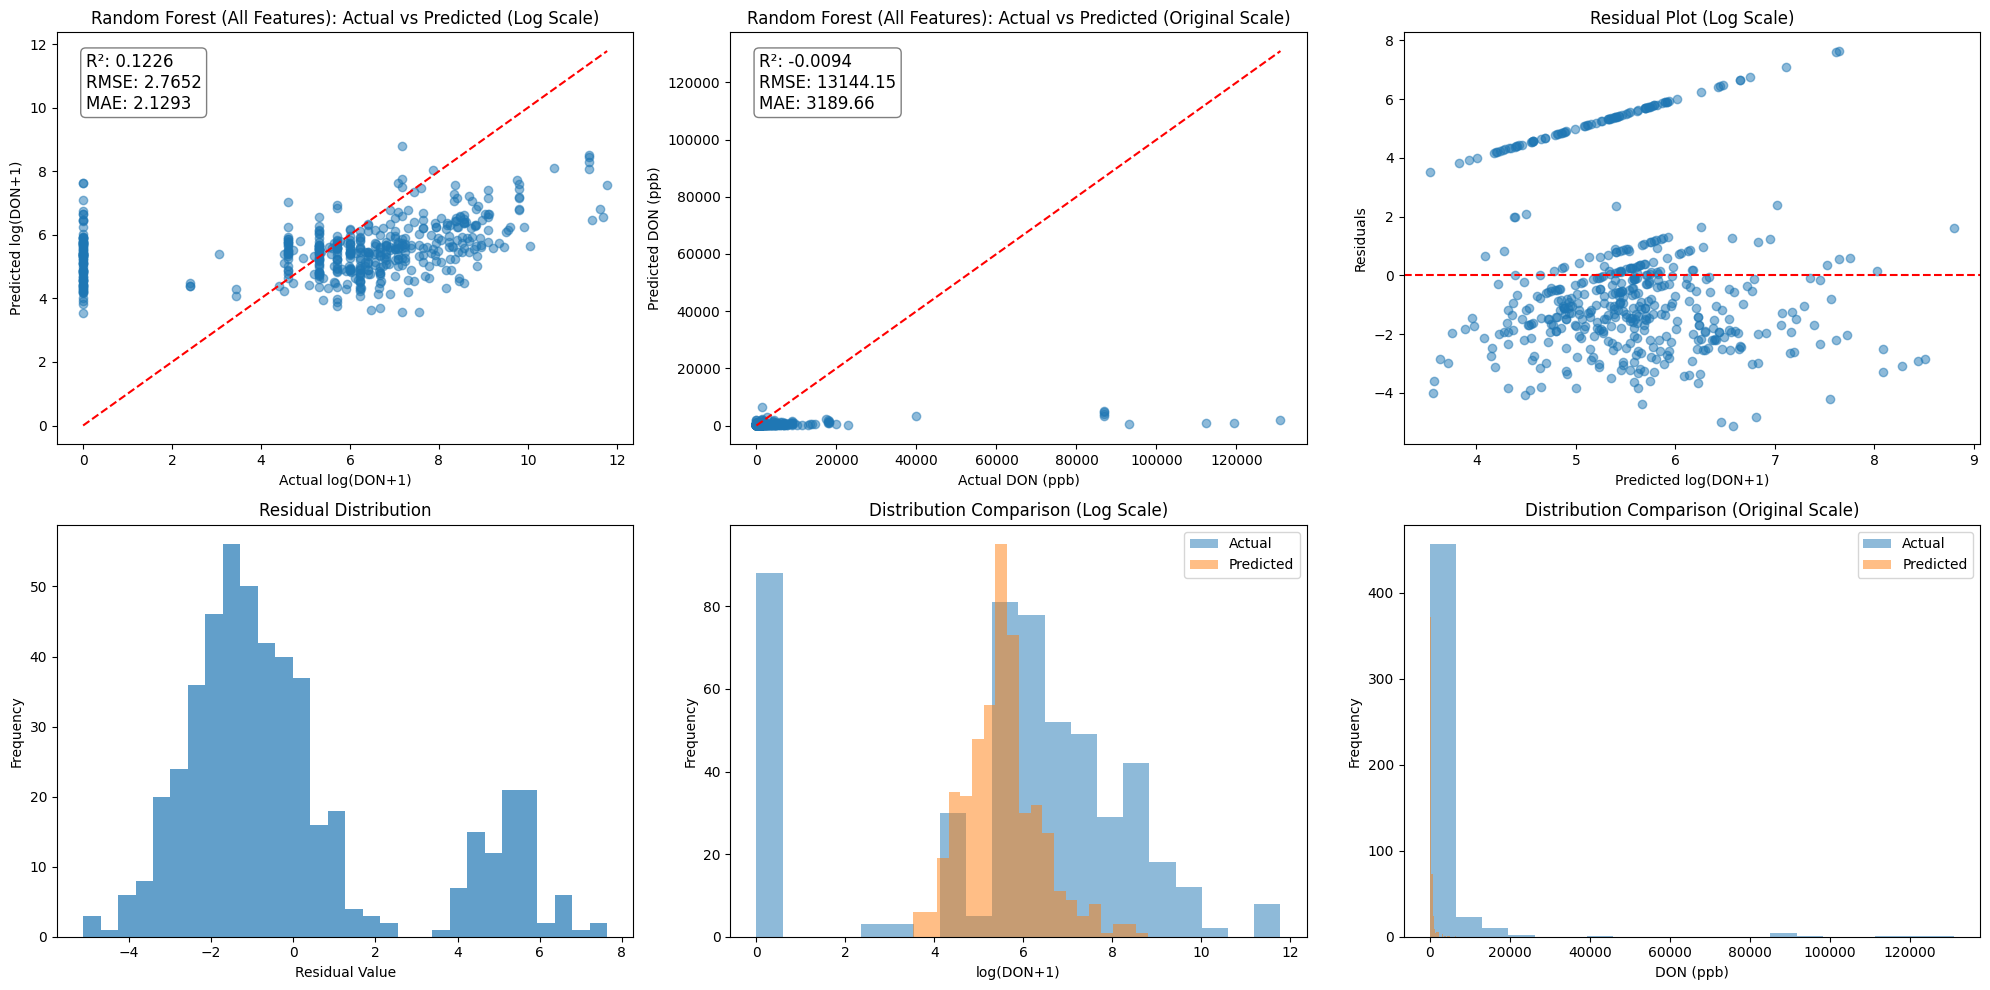


Creating diverse ensemble model...
Model weights for diverse ensemble:
- XGBoost: 0.2287
- Gradient Boosting: 0.1740
- Random Forest: 0.2026
- SVR: 0.2207
- Kernel Ridge: 0.1740

Training all base models on appropriate feature sets...

Getting cross-validated predictions for diverse ensemble...

Diverse Ensemble Performance:
R² Score (log scale): 0.1414
RMSE (log scale): 2.7354
MAE (log scale): 2.0579

Original Scale Performance:
R² Score: 0.0369
RMSE: 12839.07
MAE: 3123.96


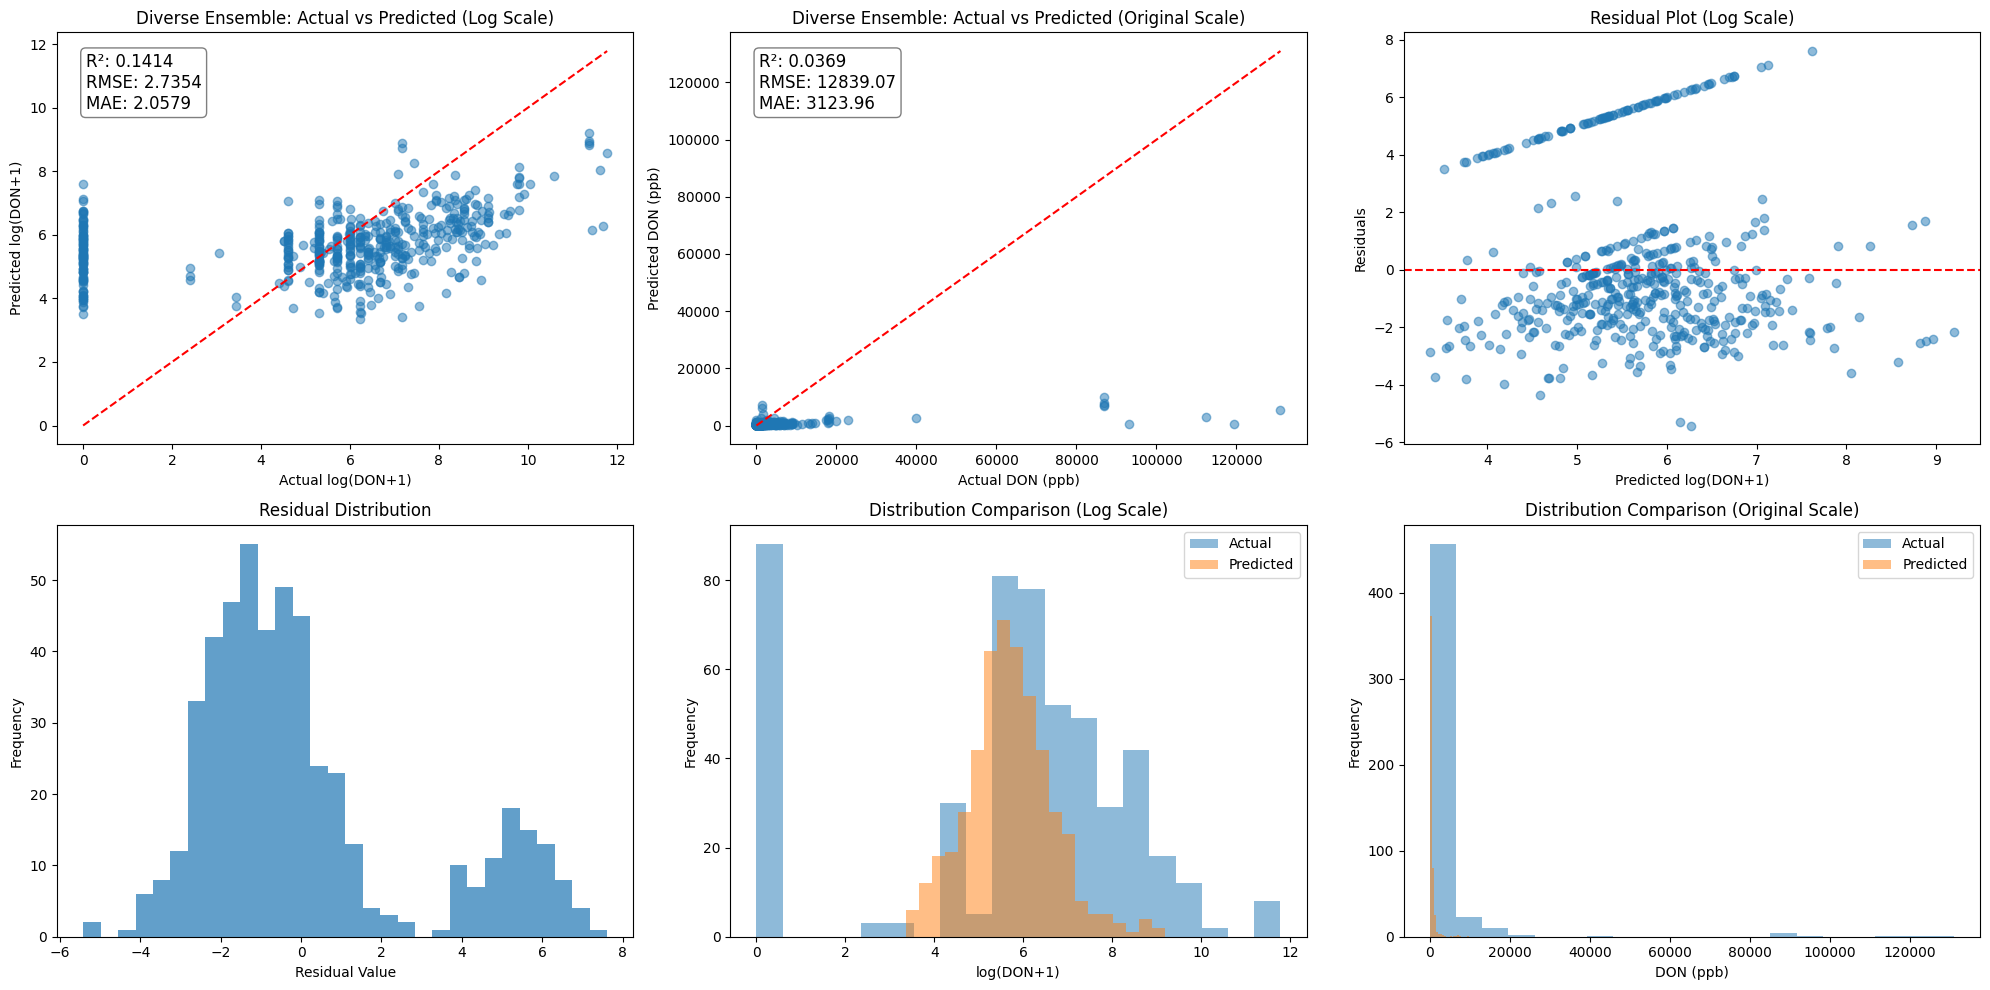


Model Comparison
Models ranked by R² in original scale:
                            Model  R² (original)  RMSE (original)  \
0           XGBoost (MI Features)       0.091653     12468.761857   
1               SVR (MI Features)       0.063095     12663.250877   
2  Gradient Boosting (F Features)       0.045018     12784.833676   
3                Diverse Ensemble       0.036898     12839.069003   
4    Random Forest (All Features)      -0.009416     13144.147208   
5       Kernel Ridge (F Features)      -0.035505     13312.923376   

   MAE (original)  
0     3126.395953  
1     3044.492542  
2     3190.596652  
3     3123.955066  
4     3189.663353  
5     3200.562554  


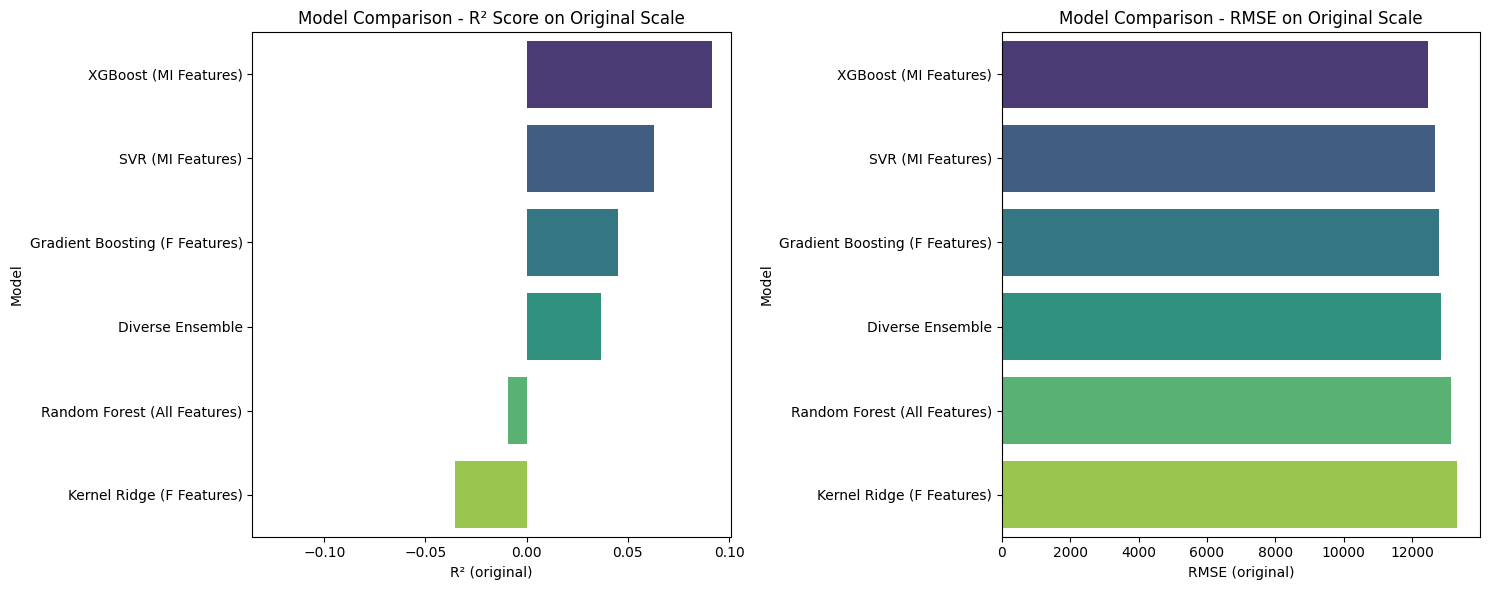


Best Model (by R² on original scale):
Model: XGBoost (MI Features)
R² Score (original): 0.0917
RMSE (original): 12468.76
MAE (original): 3126.40


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility - try different seed
np.random.seed(123)

# Load the original data
X = pd.read_csv('X_data.csv').values
y = pd.read_csv('Y_data.csv').values.ravel()  # Assuming Y is already log-transformed

print(f"Original X shape: {X.shape}")
print(f"Original y shape: {y.shape}")

# ===========================================================================
# STRATEGY 1: Create derivative features for spectral data
# ===========================================================================
print("\nCreating derivative features...")
# First derivatives
X_derivatives = np.zeros((X.shape[0], X.shape[1] - 1))
for i in range(X.shape[1] - 1):
    X_derivatives[:, i] = X[:, i+1] - X[:, i]

# Add band ratios for every 50 wavelengths
X_ratios = np.zeros((X.shape[0], 8))
for i in range(8):
    idx1 = 50 * i
    idx2 = min(idx1 + 50, X.shape[1] - 1)
    if idx1 < X.shape[1] and idx2 < X.shape[1]:
        X_ratios[:, i] = X[:, idx1] / np.maximum(X[:, idx2], 0.001)  # Avoid division by zero

# Combine original features with derivatives and ratios
X_combined = np.hstack((X, X_derivatives, X_ratios))
print(f"Combined features shape: {X_combined.shape}")

# ===========================================================================
# STRATEGY 2: Use RobustScaler (more robust to outliers)
# ===========================================================================
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_combined)

# ===========================================================================
# STRATEGY 3: Feature selection based on mutual information
# ===========================================================================
print("\nSelecting best features...")
# Try different feature selection methods
k_features = 150  # Number of features to select

# Using mutual information (captures non-linear relationships)
selector_mi = SelectKBest(mutual_info_regression, k=k_features)
X_selected_mi = selector_mi.fit_transform(X_scaled, y)

# Using F-statistic (captures linear relationships)
selector_f = SelectKBest(f_regression, k=k_features)
X_selected_f = selector_f.fit_transform(X_scaled, y)

print(f"Selected {X_selected_mi.shape[1]} features using mutual information")
print(f"Selected {X_selected_f.shape[1]} features using F-regression")

# We'll use both feature sets in different models to compare performance

# Define cross-validation with different random seed
k_folds = 5
cv = KFold(n_splits=k_folds, shuffle=True, random_state=123)

# Function to evaluate model using cross-validation
def evaluate_model_cv(model, X, y, model_name, cv=cv):
    # Perform cross-validation
    print(f"\nPerforming {k_folds}-fold cross-validation for {model_name}...")
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
    
    # Get cross-validated predictions
    y_pred_cv = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
    
    # Calculate metrics on log scale
    r2 = r2_score(y, y_pred_cv)
    mse = mean_squared_error(y, y_pred_cv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred_cv)
    
    # Calculate metrics on original scale
    y_orig = np.expm1(y)
    y_pred_orig = np.expm1(y_pred_cv)
    y_pred_orig = np.maximum(y_pred_orig, 0)  # No negative predictions
    
    r2_orig = r2_score(y_orig, y_pred_orig)
    mse_orig = mean_squared_error(y_orig, y_pred_orig)
    rmse_orig = np.sqrt(mse_orig)
    mae_orig = mean_absolute_error(y_orig, y_pred_orig)
    
    # Print cross-validation results
    print(f"Cross-validation R² scores: {cv_scores}")
    print(f"Mean CV R² score: {cv_scores.mean():.4f}")
    print(f"Standard deviation: {cv_scores.std():.4f}")
    
    # Print overall metrics
    print(f"\n{model_name} Performance (using cross-validated predictions):")
    print(f"R² Score (log scale): {r2:.4f}")
    print(f"RMSE (log scale): {rmse:.4f}")
    print(f"MAE (log scale): {mae:.4f}")
    
    print(f"\nOriginal Scale Performance:")
    print(f"R² Score: {r2_orig:.4f}")
    print(f"RMSE: {rmse_orig:.2f}")
    print(f"MAE: {mae_orig:.2f}")
    
    # Create visualization plots
    plt.figure(figsize=(20, 10))
    
    # Actual vs Predicted (log scale)
    plt.subplot(2, 3, 1)
    plt.scatter(y, y_pred_cv, alpha=0.5)
    
    # Add perfect prediction line
    max_val = max(max(y), max(y_pred_cv))
    min_val = min(min(y), min(y_pred_cv))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.title(f'{model_name}: Actual vs Predicted (Log Scale)')
    plt.xlabel('Actual log(DON+1)')
    plt.ylabel('Predicted log(DON+1)')
    plt.text(0.05, 0.95, f'R²: {r2:.4f}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}',
             transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # Actual vs Predicted (original scale)
    plt.subplot(2, 3, 2)
    plt.scatter(y_orig, y_pred_orig, alpha=0.5)
    max_val = max(max(y_orig), max(y_pred_orig))
    min_val = min(min(y_orig), min(y_pred_orig))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.title(f'{model_name}: Actual vs Predicted (Original Scale)')
    plt.xlabel('Actual DON (ppb)')
    plt.ylabel('Predicted DON (ppb)')
    plt.text(0.05, 0.95, f'R²: {r2_orig:.4f}\nRMSE: {rmse_orig:.2f}\nMAE: {mae_orig:.2f}',
             transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # Rest of the visualization code (residuals, histograms, etc.)
    plt.subplot(2, 3, 3)
    residuals = y_pred_cv - y
    plt.scatter(y_pred_cv, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot (Log Scale)')
    plt.xlabel('Predicted log(DON+1)')
    plt.ylabel('Residuals')
    
    plt.subplot(2, 3, 4)
    plt.hist(residuals, bins=30, alpha=0.7)
    plt.title('Residual Distribution')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 3, 5)
    plt.hist(y, bins=20, alpha=0.5, label='Actual')
    plt.hist(y_pred_cv, bins=20, alpha=0.5, label='Predicted')
    plt.title('Distribution Comparison (Log Scale)')
    plt.xlabel('log(DON+1)')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.subplot(2, 3, 6)
    plt.hist(y_orig, bins=20, alpha=0.5, label='Actual')
    plt.hist(y_pred_orig, bins=20, alpha=0.5, label='Predicted')
    plt.title('Distribution Comparison (Original Scale)')
    plt.xlabel('DON (ppb)')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Fit model on full dataset for later use
    model.fit(X, y)
    
    return {
        'model_name': model_name,
        'cv_scores': cv_scores,
        'mean_cv_r2': cv_scores.mean(),
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'r2_orig': r2_orig,
        'rmse_orig': rmse_orig,
        'mae_orig': mae_orig,
        'model': model
    }

# ===========================================================================
# STRATEGY 4: Try models with optimized hyperparameters
# ===========================================================================
print("\nEvaluating optimized models...")

# Model 1: Optimized XGBoost with MI-selected features
xgb_opt = XGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=2.0,
    random_state=123
)
xgb_results = evaluate_model_cv(xgb_opt, X_selected_mi, y, "XGBoost (MI Features)")

# Model 2: Optimized Gradient Boosting with F-selected features
gb_opt = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.7,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features=0.7,
    random_state=123
)
gb_results = evaluate_model_cv(gb_opt, X_selected_f, y, "Gradient Boosting (F Features)")

# Model 3: Adding kernel methods - SVR with MI features
svr_opt = SVR(
    kernel='rbf', 
    C=10, 
    gamma='scale', 
    epsilon=0.1
)
svr_results = evaluate_model_cv(svr_opt, X_selected_mi, y, "SVR (MI Features)")

# Model 4: Adding kernel methods - KernelRidge with F features
kr_opt = KernelRidge(
    alpha=0.1, 
    kernel='rbf', 
    gamma=0.1
)
kr_results = evaluate_model_cv(kr_opt, X_selected_f, y, "Kernel Ridge (F Features)")

# Model 5: RandomForest with all features
rf_opt = RandomForestRegressor(
    n_estimators=500,
    max_depth=8,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=0.3,
    bootstrap=True,
    n_jobs=-1,
    random_state=123
)
rf_results = evaluate_model_cv(rf_opt, X_scaled, y, "Random Forest (All Features)")

# ===========================================================================
# STRATEGY 5: Create an ensemble with diverse base learners
# ===========================================================================
print("\nCreating diverse ensemble model...")

# Define optimized base models for the ensemble
xgb_base = XGBRegressor(n_estimators=200, learning_rate=0.01, max_depth=3, random_state=123)
gb_base = GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, max_depth=3, random_state=123)
rf_base = RandomForestRegressor(n_estimators=200, max_depth=8, max_features=0.3, random_state=123)
svr_base = SVR(kernel='rbf', C=10, gamma='scale', epsilon=0.1)
kr_base = KernelRidge(alpha=0.1, kernel='rbf', gamma=0.1)

# Get cross-validation scores for weighting
all_cv_scores = {
    'XGBoost': xgb_results['mean_cv_r2'],
    'Gradient Boosting': gb_results['mean_cv_r2'],
    'Random Forest': rf_results['mean_cv_r2'],
    'SVR': svr_results['mean_cv_r2'],
    'Kernel Ridge': kr_results['mean_cv_r2']
}

# Get positive weights even if some R² values are negative
model_weights = {name: max(0.1, score) for name, score in all_cv_scores.items()}
total = sum(model_weights.values())
model_weights = {name: weight/total for name, weight in model_weights.items()}

print("Model weights for diverse ensemble:")
for name, weight in model_weights.items():
    print(f"- {name}: {weight:.4f}")

# Create voting ensemble with diverse models
voting_diverse = VotingRegressor(
    estimators=[
        ('xgb', xgb_base),
        ('gb', gb_base),
        ('rf', rf_base),
        ('svr', svr_base),
        ('kr', kr_base)
    ],
    weights=[
        model_weights['XGBoost'],
        model_weights['Gradient Boosting'],
        model_weights['Random Forest'],
        model_weights['SVR'],
        model_weights['Kernel Ridge']
    ]
)

# For each model, determine which feature set worked best
feature_sets = {}
for model_name, result in [
    ('XGBoost', xgb_results),
    ('Gradient Boosting', gb_results),
    ('Random Forest', rf_results),
    ('SVR', svr_results),
    ('Kernel Ridge', kr_results)
]:
    # Assign feature set based on which was used in evaluation
    if model_name == 'XGBoost' or model_name == 'SVR':
        feature_sets[model_name] = X_selected_mi
    elif model_name == 'Gradient Boosting' or model_name == 'Kernel Ridge':
        feature_sets[model_name] = X_selected_f
    else:
        feature_sets[model_name] = X_scaled

# Create a custom function to make predictions with the diverse ensemble
def predict_with_diverse_ensemble(X):
    # Prepare transformed feature sets
    X_scaled_new = scaler.transform(X)
    X_mi_new = selector_mi.transform(X_scaled_new)
    X_f_new = selector_f.transform(X_scaled_new)
    
    # Get predictions from each model using appropriate feature set
    preds = []
    weights = []
    
    # XGBoost prediction
    xgb_pred = xgb_base.predict(X_mi_new)  # Using MI features
    preds.append(xgb_pred)
    weights.append(model_weights['XGBoost'])
    
    # Gradient Boosting prediction
    gb_pred = gb_base.predict(X_f_new)  # Using F features
    preds.append(gb_pred)
    weights.append(model_weights['Gradient Boosting'])
    
    # Random Forest prediction
    rf_pred = rf_base.predict(X_scaled_new)  # Using all features
    preds.append(rf_pred)
    weights.append(model_weights['Random Forest'])
    
    # SVR prediction
    svr_pred = svr_base.predict(X_mi_new)  # Using MI features
    preds.append(svr_pred)
    weights.append(model_weights['SVR'])
    
    # Kernel Ridge prediction
    kr_pred = kr_base.predict(X_f_new)  # Using F features
    preds.append(kr_pred)
    weights.append(model_weights['Kernel Ridge'])
    
    # Calculate weighted average
    weighted_preds = np.zeros_like(xgb_pred)
    for pred, weight in zip(preds, weights):
        weighted_preds += pred * weight
    
    return weighted_preds

# Train all base models on their best feature sets
print("\nTraining all base models on appropriate feature sets...")
xgb_base.fit(X_selected_mi, y)
gb_base.fit(X_selected_f, y)
rf_base.fit(X_scaled, y)
svr_base.fit(X_selected_mi, y)
kr_base.fit(X_selected_f, y)

# Get cross-validated predictions from diverse ensemble
print("\nGetting cross-validated predictions for diverse ensemble...")
y_pred_diverse = np.zeros_like(y)

# Perform cross-validation manually
for train_idx, test_idx in cv.split(X):
    # Get training and test data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test_fold = y[train_idx], y[test_idx]
    
    # Transform data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Feature selection
    X_train_mi = selector_mi.fit_transform(X_train_scaled, y_train)
    X_test_mi = selector_mi.transform(X_test_scaled)
    
    X_train_f = selector_f.fit_transform(X_train_scaled, y_train)
    X_test_f = selector_f.transform(X_test_scaled)
    
    # Train models on their preferred feature sets
    xgb_base.fit(X_train_mi, y_train)
    gb_base.fit(X_train_f, y_train)
    rf_base.fit(X_train_scaled, y_train)
    svr_base.fit(X_train_mi, y_train)
    kr_base.fit(X_train_f, y_train)
    
    # Get predictions from each model
    xgb_pred = xgb_base.predict(X_test_mi)
    gb_pred = gb_base.predict(X_test_f)
    rf_pred = rf_base.predict(X_test_scaled)
    svr_pred = svr_base.predict(X_test_mi)
    kr_pred = kr_base.predict(X_test_f)
    
    # Weighted average
    y_pred_fold = (
        xgb_pred * model_weights['XGBoost'] +
        gb_pred * model_weights['Gradient Boosting'] +
        rf_pred * model_weights['Random Forest'] +
        svr_pred * model_weights['SVR'] +
        kr_pred * model_weights['Kernel Ridge']
    )
    
    # Store predictions
    y_pred_diverse[test_idx] = y_pred_fold

# Calculate metrics for diverse ensemble
r2_diverse = r2_score(y, y_pred_diverse)
mse_diverse = mean_squared_error(y, y_pred_diverse)
rmse_diverse = np.sqrt(mse_diverse)
mae_diverse = mean_absolute_error(y, y_pred_diverse)

# Original scale metrics
y_orig = np.expm1(y)
y_pred_diverse_orig = np.expm1(y_pred_diverse)
y_pred_diverse_orig = np.maximum(y_pred_diverse_orig, 0)  # No negative predictions

r2_diverse_orig = r2_score(y_orig, y_pred_diverse_orig)
mse_diverse_orig = mean_squared_error(y_orig, y_pred_diverse_orig)
rmse_diverse_orig = np.sqrt(mse_diverse_orig)
mae_diverse_orig = mean_absolute_error(y_orig, y_pred_diverse_orig)

print("\nDiverse Ensemble Performance:")
print(f"R² Score (log scale): {r2_diverse:.4f}")
print(f"RMSE (log scale): {rmse_diverse:.4f}")
print(f"MAE (log scale): {mae_diverse:.4f}")

print(f"\nOriginal Scale Performance:")
print(f"R² Score: {r2_diverse_orig:.4f}")
print(f"RMSE: {rmse_diverse_orig:.2f}")
print(f"MAE: {mae_diverse_orig:.2f}")

# Create visualization for diverse ensemble
plt.figure(figsize=(20, 10))

# Actual vs Predicted (log scale)
plt.subplot(2, 3, 1)
plt.scatter(y, y_pred_diverse, alpha=0.5)
max_val = max(max(y), max(y_pred_diverse))
min_val = min(min(y), min(y_pred_diverse))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Diverse Ensemble: Actual vs Predicted (Log Scale)')
plt.xlabel('Actual log(DON+1)')
plt.ylabel('Predicted log(DON+1)')
plt.text(0.05, 0.95, f'R²: {r2_diverse:.4f}\nRMSE: {rmse_diverse:.4f}\nMAE: {mae_diverse:.4f}',
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Actual vs Predicted (original scale)
plt.subplot(2, 3, 2)
plt.scatter(y_orig, y_pred_diverse_orig, alpha=0.5)
max_val = max(max(y_orig), max(y_pred_diverse_orig))
min_val = min(min(y_orig), min(y_pred_diverse_orig))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Diverse Ensemble: Actual vs Predicted (Original Scale)')
plt.xlabel('Actual DON (ppb)')
plt.ylabel('Predicted DON (ppb)')
plt.text(0.05, 0.95, f'R²: {r2_diverse_orig:.4f}\nRMSE: {rmse_diverse_orig:.2f}\nMAE: {mae_diverse_orig:.2f}',
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Rest of the visualization
plt.subplot(2, 3, 3)
residuals = y_pred_diverse - y
plt.scatter(y_pred_diverse, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot (Log Scale)')
plt.xlabel('Predicted log(DON+1)')
plt.ylabel('Residuals')

plt.subplot(2, 3, 4)
plt.hist(residuals, bins=30, alpha=0.7)
plt.title('Residual Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')

plt.subplot(2, 3, 5)
plt.hist(y, bins=20, alpha=0.5, label='Actual')
plt.hist(y_pred_diverse, bins=20, alpha=0.5, label='Predicted')
plt.title('Distribution Comparison (Log Scale)')
plt.xlabel('log(DON+1)')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 3, 6)
plt.hist(y_orig, bins=20, alpha=0.5, label='Actual')
plt.hist(y_pred_diverse_orig, bins=20, alpha=0.5, label='Predicted')
plt.title('Distribution Comparison (Original Scale)')
plt.xlabel('DON (ppb)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# ===========================================================================
# Model Comparison and Final Results
# ===========================================================================
# Collect all results
diverse_results = {
    'model_name': 'Diverse Ensemble',
    'mean_cv_r2': r2_diverse,  # Not technically CV R² but we'll use it for comparison
    'r2': r2_diverse,
    'rmse': rmse_diverse,
    'mae': mae_diverse,
    'r2_orig': r2_diverse_orig,
    'rmse_orig': rmse_diverse_orig,
    'mae_orig': mae_diverse_orig
}

# Compare all models
print("\n" + "="*50)
print("Model Comparison")
print("="*50)

# Gather results
all_results = [
    xgb_results, 
    gb_results, 
    rf_results, 
    svr_results, 
    kr_results, 
    diverse_results
]

# Create comparison DataFrame for results
comparison = pd.DataFrame([
    {
        'Model': result['model_name'],
        'R² (log scale)': result['r2'],
        'RMSE (log scale)': result['rmse'],
        'MAE (log scale)': result['mae'],
        'R² (original)': result['r2_orig'],
        'RMSE (original)': result['rmse_orig'],
        'MAE (original)': result['mae_orig']
    }
    for result in all_results
])

# Sort by R² on original scale
comparison = comparison.sort_values('R² (original)', ascending=False).reset_index(drop=True)
print("Models ranked by R² in original scale:")
print(comparison[['Model', 'R² (original)', 'RMSE (original)', 'MAE (original)']])

# Plot comparison
plt.figure(figsize=(15, 6))

# R² comparison (higher is better)
plt.subplot(1, 2, 1)
sns.barplot(x='R² (original)', y='Model', data=comparison, palette='viridis')
plt.title('Model Comparison - R² Score on Original Scale')
plt.xlim(max(min(comparison['R² (original)']) - 0.1, -0.2), max(comparison['R² (original)']) * 1.1)

# RMSE comparison (lower is better)
plt.subplot(1, 2, 2)
sns.barplot(x='RMSE (original)', y='Model', data=comparison, palette='viridis')
plt.title('Model Comparison - RMSE on Original Scale')

plt.tight_layout()
plt.show()

# Highlight best model
best_model_row = comparison.iloc[0]
print("\nBest Model (by R² on original scale):")
print(f"Model: {best_model_row['Model']}")
print(f"R² Score (original): {best_model_row['R² (original)']:.4f}")
print(f"RMSE (original): {best_model_row['RMSE (original)']:.2f}")
print(f"MAE (original): {best_model_row['MAE (original)']:.2f}")